# Effect of the planarity decriptor (MPP), Scaffold descriptors and other structural descriptors on Ered predictions

## Notebook will show that these descriptors doesn't significantly improve the Ered prediction accuracy  of the GPR model

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns

import rdkit.Chem as Chem

In [208]:
ERed_data=pd.read_csv(r"./Data/BTZ_smi_Ered_MPP_2763.csv",usecols=["SMILES","Ered_ag","MPP(A)"])
ERed_data.head()

SMILES    MPP(A)  Ered_ag
0   Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C  0.908587    -2.58
1       CCN1CCN(CCOC)c2c1cc1nsnc1c2C  0.799408    -2.58
2   CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C  1.279319    -2.61
3    CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21  1.039480    -2.63
4  CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C  1.296932    -2.65

# Checking for duplicate smiles

In [209]:
def remove_duplicate_smi(df,smi_col="SMILES"):
    """ df: dataframe with the 'SMILES' column """
    temp=df.shape[0]
    print(f"Before: df.shape={df.shape}")
    df[smi_col]=df[smi_col].apply(lambda smi:Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
    df=df.drop_duplicates(subset=smi_col)
    print(f"After: df.shape={df.shape}")
    print(f"Removed {df.shape[0]-temp} duplicate smiles")
    return df


In [210]:
ERed_data=remove_duplicate_smi(df=ERed_data,smi_col="SMILES")

Before: df.shape=(2763, 3)
After: df.shape=(2763, 3)
Removed 0 duplicate smiles


# No duplicate SMILES found

In [211]:
ERed_data.index=np.arange(len(ERed_data))
ERed_data.head()

SMILES    MPP(A)  Ered_ag
0   Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C  0.908587    -2.58
1       CCN1CCN(CCOC)c2c1cc1nsnc1c2C  0.799408    -2.58
2   CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C  1.279319    -2.61
3    CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21  1.039480    -2.63
4  CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C  1.296932    -2.65

# Feature Generation with the mordred

In [212]:
def All_Mordred_descriptors(data,ignore_3D=True):
    """
    Function will return all mordred features
    """
    from mordred import Calculator, descriptors
    from rdkit.Chem import AllChem
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    # mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in data]
    mols = []
    for smi in data:
        m=Chem.MolFromSmiles(smi)
        # m=Chem.AddHs(m) # for 3D descriptors
        # AllChem.EmbedMolecule(m) # for 3D descriptors
        # AllChem.UFFOptimizeMolecule(m)  # for 3D descriptors
        mols.append(m)
    # pandas df
    df = calc.pandas(mols)
    return df

In [213]:
# call function
df_mordred=All_Mordred_descriptors(ERed_data.SMILES)
df_rdkit=df_mordred.copy()

100%|██████████| 2763/2763 [01:02<00:00, 44.15it/s]


# Keep only int, bool and float features

In [214]:
# df_rdkit=df_mordred.copy()
df_rdkit=df_rdkit.select_dtypes(exclude='object')

# Add [Molecular planarity parameter (MPP)](https://link.springer.com/article/10.1007/s00894-021-04884-0) of all atoms to the feature set
## MPP of all atoms and only heavy atoms are highly correlated. Hence, I only use the MPP of all atoms

In [215]:
ERed_data

SMILES    MPP(A)  Ered_ag
0      Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C  0.908587    -2.58
1          CCN1CCN(CCOC)c2c1cc1nsnc1c2C  0.799408    -2.58
2      CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C  1.279319    -2.61
3       CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21  1.039480    -2.63
4     CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C  1.296932    -2.65
...                                 ...       ...      ...
2758   CCCN1CCN(CCOCC)c2cc3nsnc3c(C)c21  1.129065    -2.60
2759     CCC(C)OCCN1CN(C)c2cc3nsnc3cc21  1.075593    -2.74
2760   CCN(C)c1c2c(cc3nsnc13)N(CC)CN2CC  1.195435    -2.78
2761       CCCCOCCN1CN(C)c2cc3nsnc3cc21  0.722666    -2.72
2762        CCOCCOCCN1CCOc2c1ccc1nsnc21  0.735573    -2.36

[2763 rows x 3 columns]

In [216]:
df_rdkit.insert(0,"MPP(A)",ERed_data["MPP(A)"].to_list())
ERed_data=ERed_data.drop(columns=["MPP(A)"])

In [217]:
pd.set_option('display.max_columns', None)

In [218]:
df_rdkit.head()

MPP(A)        ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  \
0  0.908587  15.751268  13.427666      0      1  25.630471  2.519739   
1  0.799408  15.423098  13.290233      0      0  26.324434  2.523931   
2  1.279319  15.601438  13.731731      0      0  25.692299  2.536570   
3  1.039480  16.020815  14.010589      0      0  27.401753  2.533995   
4  1.296932  16.199155  14.278162      0      0  27.143468  2.540831   

   SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A  \
0  5.006345  25.630471  1.281524  3.941813  3.875428  0.193771  2.047803   
1  5.015985  26.324434  1.316222  3.938060  3.899598  0.194980  2.054021   
2  5.042661  25.692299  1.284615  3.942218  3.967340  0.198367  2.071243   
3  5.036602  27.401753  1.304845  3.981718  3.975880  0.189328  2.122183   
4  5.052381  27.143468  1.292546  3.985690  4.020873  0.191470  2.133436   

        VR1_A     VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  \
0  181.928976  9.096449  5.896764          9         10     41          20   
1  173.385876  8.669294  5.848667          9         10     40          20   
2  126.083770  6.304189  5.530094          9         10     41          20   
3  156.798836  7.466611  5.796901          9         10     44          21   
4  139.986453  6.666022  5.683483          9         10     44          21   

   nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  \
0       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
1       0            0        6  20   0  14   4   1   1   0   0    0    0   0   
2       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
3       0            0        6  23   0  15   5   0   1   0   0    0    0   0   
4       0            0        6  23   0  15   5   0   1   0   0    0    0   0   

   nX      ATS0dv      ATS1dv      ATS2dv      ATS3dv  ATS4dv      ATS5dv  \
0   0  234.444444  241.666667  355.333333  341.666667   280.0  212.666667   
1   0  248.444444  246.666667  365.333333  359.666667   303.0  241.666667   
2   0  230.444444  250.666667  383.333333  396.666667   353.0  231.000000   
3   0  232.444444  252.666667  389.333333  406.666667   365.0  257.000000   
4   0  234.444444  257.666667  394.333333  411.666667   375.0  260.000000   

       ATS6dv     ATS7dv     ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  \
0  144.666667  87.333333  48.333333  129.0  160.0  279.0  303.0  323.0  304.0   
1  167.333333  98.000000  51.000000  126.0  160.0  271.0  306.0  319.0  309.0   
2   94.000000  16.333333   0.000000  129.0  163.0  280.0  322.0  339.0  333.0   
3  128.000000  40.000000   8.666667  133.0  171.0  288.0  338.0  355.0  356.0   
4  119.666667  27.000000   1.000000  135.0  172.0  294.0  346.0  366.0  370.0   

   ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s  \
0  239.0  203.0  121.0   94.308985  108.166667  179.021605  210.598765   
1  250.0  180.0  105.0   99.808985  108.416667  182.688272  204.682099   
2  283.0  193.0  102.0   96.086763  108.333333  182.327160  219.876543   
3  324.0  239.0  144.0   99.058985  112.250000  190.271605  224.348765   
4  329.0  232.0  135.0  100.336763  113.333333  192.243827  231.459877   

        ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z  \
0  242.688272  234.703704  214.712963  186.138889  127.259259  1026.0  1136.0   
1  232.438272  252.370370  234.138889  194.203704  121.842593  1040.0  1136.0   
2  243.067901  268.268519  269.280864  209.722222  118.388889  1026.0  1131.0   
3  243.679012  276.046296  284.814815  236.064815  157.037037  1064.0  1179.0   
4  255.567901  293.851852  297.206790  241.370370  160.333333  1064.0  1179.0   

    ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z  ATS8Z        ATS0m  \
0  1570.0  1724.0  1809.0  1626.0  1477.0  1035.0  672.0  4049.858883   
1  1551.0  1718.0  1870.0  1717.0  1539.0  1081.0  631.0  4108.614771   
2  1586.0  1776.0  1986.0  1967.0  1784.0  1064.0  328.0  

## Add more ringstats (Eli's suggestion)

# Add number of rings of different size

In [219]:
def ring_stats(smiles):
    """
    if smi="CN1CN(C)c2cc3nsnc3cc21" 
    then ring_stats(smi) will return a list of number of rings of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    # rings start with size 3
    Output:    [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0]
    molecule has 2 and 1 rings of size 5 and 6, respectively
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nring=[0]*d
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            nring[n]+=1 # total rings
    return nring    

In [220]:
def hetroring_stats(smiles):
    """
    Retrun a list of number of hetrocylces of sizes from 3 to 13

    Eg. if smi="CN1CN(C)c2cc3nsnc3cc21" 
    # rings start with size 3
    then the hetroring_stats(smi) will return :  hetrocycle ring of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    Output: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
    There are 2 hetrorings of size 5
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nHring=[0]*d
    
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            c=sr.count('C')
            if(c<n): # hetro-atom cycle
                nHring[n]+=1
    return nHring    

In [221]:
def other_ring_stats(smiles):
    """
    Return a list which contains [number of carbon atoms (nC) in all homocycles, nC in all heterocycles,nN in all hetrocycle, nS in all hetrocycles, nO in all hetrocycles ]
    """
    m = Chem.MolFromSmiles(smiles)
    
    numH_C,numH_N,numH_S,numH_O=0,0,0,0
    num_C_homo=0
    ri=m.GetRingInfo()
    
    for r in ri.AtomRings():
        sr=""
        ringsize=0
        for i in r:
            sr+=m.GetAtomWithIdx(i).GetSymbol()
            ringsize+=1
        # print(sr)
        num_c=sr.count('C')
        
        # count number of S, N, C, and O in hetrocycles
        if  num_c < ringsize: # count in hetrocycles
            numH_C+=num_c
            numH_N+=sr.count('N')
            numH_S+=sr.count('S')
            numH_O+=sr.count('O')
        else:
            num_C_homo+=ringsize
    return [num_C_homo,numH_C,numH_N,numH_O,numH_S]

# add features with ring_stats()

In [222]:
new_col=ERed_data["SMILES"].apply(lambda smi:ring_stats(smi)).to_list()
col_txt=["nring"+str(i) for i in range(len(new_col[0]))]

df_ring=pd.DataFrame(new_col,columns=col_txt)
# drop columns with only 0 value
df_ring=df_ring.drop(df_ring.columns[df_ring.eq(0).all()],axis=1)

# add features with hetroring_stats()

In [223]:
new_col=ERed_data["SMILES"].apply(lambda smi:hetroring_stats(smi)).to_list()
col_txt=["nHring"+str(i) for i in range(len(new_col[0]))]

df_Hring=pd.DataFrame(new_col,columns=col_txt)
df_Hring=df_Hring.drop(df_Hring.columns[df_Hring.eq(0).all()],axis=1)

# add_features with other_ring_stats()
## number of C, N, O and S in homo- and hetro-atom cycles

In [224]:
new_col=ERed_data["SMILES"].apply(lambda smi:other_ring_stats(smi)).to_list()
col_txt=["nhomo_C","nhetro_C","nhetro_N","nhetro_O","nhetro_S"]
df_NAring=pd.DataFrame(new_col,columns=col_txt)
df_NAring=df_NAring.drop(df_NAring.columns[df_NAring.eq(0).all()],axis=1)

# Add new features to the df_rdkit

In [225]:
df=pd.concat([df_rdkit,df_ring,df_Hring,df_NAring],axis=1)
print(df.shape)
df.head()

(2763, 1305)


MPP(A)        ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  \
0  0.908587  15.751268  13.427666      0      1  25.630471  2.519739   
1  0.799408  15.423098  13.290233      0      0  26.324434  2.523931   
2  1.279319  15.601438  13.731731      0      0  25.692299  2.536570   
3  1.039480  16.020815  14.010589      0      0  27.401753  2.533995   
4  1.296932  16.199155  14.278162      0      0  27.143468  2.540831   

   SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A  \
0  5.006345  25.630471  1.281524  3.941813  3.875428  0.193771  2.047803   
1  5.015985  26.324434  1.316222  3.938060  3.899598  0.194980  2.054021   
2  5.042661  25.692299  1.284615  3.942218  3.967340  0.198367  2.071243   
3  5.036602  27.401753  1.304845  3.981718  3.975880  0.189328  2.122183   
4  5.052381  27.143468  1.292546  3.985690  4.020873  0.191470  2.133436   

        VR1_A     VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  \
0  181.928976  9.096449  5.896764          9         10     41          20   
1  173.385876  8.669294  5.848667          9         10     40          20   
2  126.083770  6.304189  5.530094          9         10     41          20   
3  156.798836  7.466611  5.796901          9         10     44          21   
4  139.986453  6.666022  5.683483          9         10     44          21   

   nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  \
0       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
1       0            0        6  20   0  14   4   1   1   0   0    0    0   0   
2       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
3       0            0        6  23   0  15   5   0   1   0   0    0    0   0   
4       0            0        6  23   0  15   5   0   1   0   0    0    0   0   

   nX      ATS0dv      ATS1dv      ATS2dv      ATS3dv  ATS4dv      ATS5dv  \
0   0  234.444444  241.666667  355.333333  341.666667   280.0  212.666667   
1   0  248.444444  246.666667  365.333333  359.666667   303.0  241.666667   
2   0  230.444444  250.666667  383.333333  396.666667   353.0  231.000000   
3   0  232.444444  252.666667  389.333333  406.666667   365.0  257.000000   
4   0  234.444444  257.666667  394.333333  411.666667   375.0  260.000000   

       ATS6dv     ATS7dv     ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  \
0  144.666667  87.333333  48.333333  129.0  160.0  279.0  303.0  323.0  304.0   
1  167.333333  98.000000  51.000000  126.0  160.0  271.0  306.0  319.0  309.0   
2   94.000000  16.333333   0.000000  129.0  163.0  280.0  322.0  339.0  333.0   
3  128.000000  40.000000   8.666667  133.0  171.0  288.0  338.0  355.0  356.0   
4  119.666667  27.000000   1.000000  135.0  172.0  294.0  346.0  366.0  370.0   

   ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s  \
0  239.0  203.0  121.0   94.308985  108.166667  179.021605  210.598765   
1  250.0  180.0  105.0   99.808985  108.416667  182.688272  204.682099   
2  283.0  193.0  102.0   96.086763  108.333333  182.327160  219.876543   
3  324.0  239.0  144.0   99.058985  112.250000  190.271605  224.348765   
4  329.0  232.0  135.0  100.336763  113.333333  192.243827  231.459877   

        ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z  \
0  242.688272  234.703704  214.712963  186.138889  127.259259  1026.0  1136.0   
1  232.438272  252.370370  234.138889  194.203704  121.842593  1040.0  1136.0   
2  243.067901  268.268519  269.280864  209.722222  118.388889  1026.0  1131.0   
3  243.679012  276.046296  284.814815  236.064815  157.037037  1064.0  1179.0   
4  255.567901  293.851852  297.206790  241.370370  160.333333  1064.0  1179.0   

    ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z  ATS8Z        ATS0m  \
0  1570.0  1724.0  1809.0  1626.0  1477.0  1035.0  672.0  4049.858883   
1  1551.0  1718.0  1870.0  1717.0  1539.0  1081.0  631.0  4108.614771   
2  1586.0  1776.0  1986.0  1967.0  1784.0  1064.0  328.0  

In [226]:
df_rdkit=df

del df, df_ring,df_Hring,df_NAring

# Label molecules by the substructure

In [227]:
def substruct_in_smi(mol_smi_str,pat_smi_str):
    """
    This function will return True if the substructure (pattern) is present in the SMILES string.
    Input: smi_str = A SMILES string;   sub_str = Pattern 
    Output: True (substruture found in the smi); False (substruture not found in the smi)
    """   
    mol = Chem.MolFromSmiles(mol_smi_str)
    pat = Chem.MolFromSmiles(pat_smi_str) 

    return mol.HasSubstructMatch(pat)

In [228]:
import datamol as dm

# Make a folder to save output files

In [229]:
import os
# Directory
directory = "planarity_hypo_test_2763btzs_mord_mpp_scaf_adRing"
  
# Parent Directory path
parent_dir = "./"
  
# Path
path = os.path.join(parent_dir, directory)
if not os.path.isdir(path):  
    os.mkdir(path)
    print("Directory '% s' created" % directory)

In [230]:
folder_path=directory+"/"

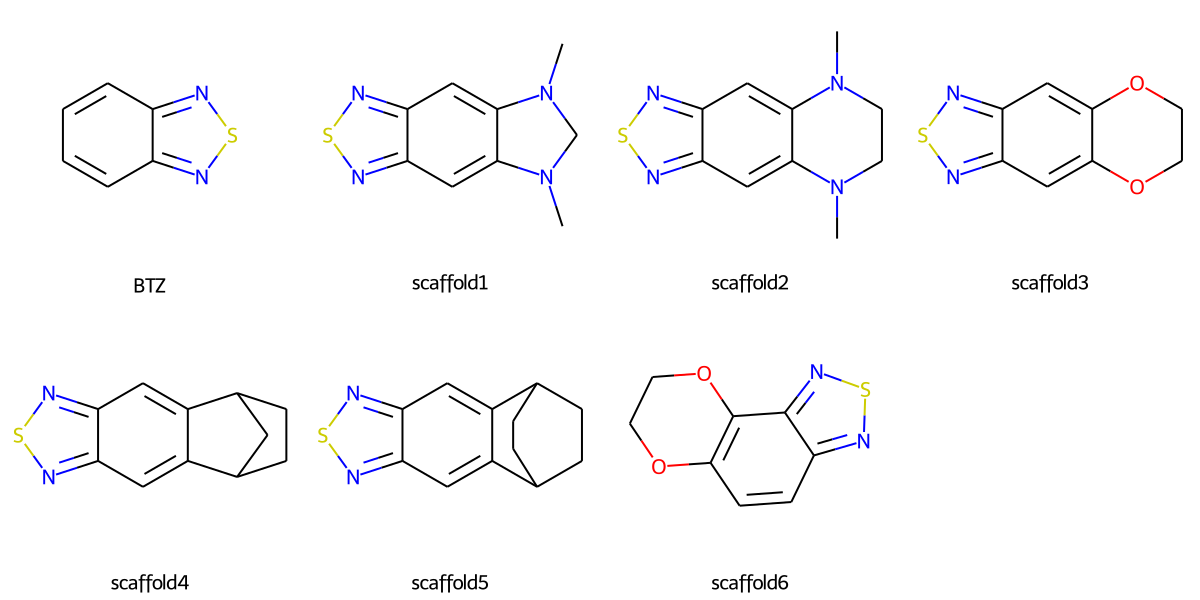

In [231]:
scaff=['c1ccc2nsnc2c1',
 'CN1CN(C)c2cc3nsnc3cc21',
 'CN1CCN(C)c2cc3nsnc3cc21',
 'c1c2c(cc3nsnc13)OCCO2',
 'c1c2c(cc3nsnc13)C1CCC2C1',
 'c1c2c(cc3nsnc13)C1CCC2CC1',
 'C1COc2c(cc(c4nsnc24))O1']

mols=[Chem.MolFromSmiles(smi) for smi in scaff]
col_txt=['BTZ','scaffold1', 'scaffold2', 'scaffold3', 'scaffold4', 'scaffold5', 'scaffold6']
dm.to_image(mols=mols,legends=col_txt,legend_fontsize=20,outfile=folder_path+"Scaffolds.png",use_svg=False)

# Make new features with the above scaffolds

In [232]:
for idx,smi in enumerate(scaff):
    col=col_txt[idx]
    df_rdkit[col]=ERed_data["SMILES"].apply(lambda x:1*substruct_in_smi(mol_smi_str=x,pat_smi_str=smi))

In [233]:
# Remove "BTZ" because all molecules have BTZ substructure 
df_rdkit=df_rdkit.drop(columns="BTZ")

# other_btzs: Molecules that don't have any of the Scaffold from Scaffold1 to Scaffold6

In [234]:
df_rdkit["other_btzs"]=0
df_rdkit["other_btzs"][(df_rdkit["scaffold1"]==0)&(df_rdkit["scaffold2"]==0)&(df_rdkit["scaffold3"]==0)&(df_rdkit["scaffold4"]==0)&(df_rdkit["scaffold5"]==0)&(df_rdkit["scaffold6"]==0)]=1

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [235]:
df_rdkit.head()

MPP(A)        ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  \
0  0.908587  15.751268  13.427666      0      1  25.630471  2.519739   
1  0.799408  15.423098  13.290233      0      0  26.324434  2.523931   
2  1.279319  15.601438  13.731731      0      0  25.692299  2.536570   
3  1.039480  16.020815  14.010589      0      0  27.401753  2.533995   
4  1.296932  16.199155  14.278162      0      0  27.143468  2.540831   

   SpDiam_A     SpAD_A   SpMAD_A   LogEE_A     VE1_A     VE2_A     VE3_A  \
0  5.006345  25.630471  1.281524  3.941813  3.875428  0.193771  2.047803   
1  5.015985  26.324434  1.316222  3.938060  3.899598  0.194980  2.054021   
2  5.042661  25.692299  1.284615  3.942218  3.967340  0.198367  2.071243   
3  5.036602  27.401753  1.304845  3.981718  3.975880  0.189328  2.122183   
4  5.052381  27.143468  1.292546  3.985690  4.020873  0.191470  2.133436   

        VR1_A     VR2_A     VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  \
0  181.928976  9.096449  5.896764          9         10     41          20   
1  173.385876  8.669294  5.848667          9         10     40          20   
2  126.083770  6.304189  5.530094          9         10     41          20   
3  156.798836  7.466611  5.796901          9         10     44          21   
4  139.986453  6.666022  5.683483          9         10     44          21   

   nSpiro  nBridgehead  nHetero  nH  nB  nC  nN  nO  nS  nP  nF  nCl  nBr  nI  \
0       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
1       0            0        6  20   0  14   4   1   1   0   0    0    0   0   
2       0            0        6  21   0  14   5   0   1   0   0    0    0   0   
3       0            0        6  23   0  15   5   0   1   0   0    0    0   0   
4       0            0        6  23   0  15   5   0   1   0   0    0    0   0   

   nX      ATS0dv      ATS1dv      ATS2dv      ATS3dv  ATS4dv      ATS5dv  \
0   0  234.444444  241.666667  355.333333  341.666667   280.0  212.666667   
1   0  248.444444  246.666667  365.333333  359.666667   303.0  241.666667   
2   0  230.444444  250.666667  383.333333  396.666667   353.0  231.000000   
3   0  232.444444  252.666667  389.333333  406.666667   365.0  257.000000   
4   0  234.444444  257.666667  394.333333  411.666667   375.0  260.000000   

       ATS6dv     ATS7dv     ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  \
0  144.666667  87.333333  48.333333  129.0  160.0  279.0  303.0  323.0  304.0   
1  167.333333  98.000000  51.000000  126.0  160.0  271.0  306.0  319.0  309.0   
2   94.000000  16.333333   0.000000  129.0  163.0  280.0  322.0  339.0  333.0   
3  128.000000  40.000000   8.666667  133.0  171.0  288.0  338.0  355.0  356.0   
4  119.666667  27.000000   1.000000  135.0  172.0  294.0  346.0  366.0  370.0   

   ATS6d  ATS7d  ATS8d       ATS0s       ATS1s       ATS2s       ATS3s  \
0  239.0  203.0  121.0   94.308985  108.166667  179.021605  210.598765   
1  250.0  180.0  105.0   99.808985  108.416667  182.688272  204.682099   
2  283.0  193.0  102.0   96.086763  108.333333  182.327160  219.876543   
3  324.0  239.0  144.0   99.058985  112.250000  190.271605  224.348765   
4  329.0  232.0  135.0  100.336763  113.333333  192.243827  231.459877   

        ATS4s       ATS5s       ATS6s       ATS7s       ATS8s   ATS0Z   ATS1Z  \
0  242.688272  234.703704  214.712963  186.138889  127.259259  1026.0  1136.0   
1  232.438272  252.370370  234.138889  194.203704  121.842593  1040.0  1136.0   
2  243.067901  268.268519  269.280864  209.722222  118.388889  1026.0  1131.0   
3  243.679012  276.046296  284.814815  236.064815  157.037037  1064.0  1179.0   
4  255.567901  293.851852  297.206790  241.370370  160.333333  1064.0  1179.0   

    ATS2Z   ATS3Z   ATS4Z   ATS5Z   ATS6Z   ATS7Z  ATS8Z        ATS0m  \
0  1570.0  1724.0  1809.0  1626.0  1477.0  1035.0  672.0  4049.858883   
1  1551.0  1718.0  1870.0  1717.0  1539.0  1081.0  631.0  4108.614771   
2  1586.0  1776.0  1986.0  1967.0  1784.0  1064.0  328.0  

# Molecules with Scaffold1 and Scaffold2 show small Ered. Add a feature scaffold12 that is 1 when a molecule has Scaffold1 or Scaffold2

In [236]:
# scaff1 and scaff2 both show small Ered; both have planar nitrogen atoms; let's put them in a single group
df_rdkit["scaffold12"]=0
df_rdkit["scaffold12"][(df_rdkit["scaffold1"]==1)|(df_rdkit["scaffold2"])]=1
# ERed_data.head()

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [237]:
print(f"shape of the features set = {df_rdkit.shape}")

shape of the features set = (2763, 1313)


# Data cleaning

In [238]:
def data_cleaning(df):
    # check columns with nan
    columns_with_nan=df.columns[df.isna().any()]
    print(f"Removing {len(columns_with_nan)} columns with nan, if any")
    print(f"Before: df.shape={df.shape}")
    df = df.dropna(axis='columns')
    # df = df.drop(columns=columns_with_nan)
    print(f"After: df.shape={df.shape} \n")    
    

    # Remove duplicates
    print(f"removing {sum(df.columns.duplicated())} duplicate columns, if any")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,~df.columns.duplicated()].copy()
    print(f"After: df.shape={df.shape} \n")
    
    
    # Remove columns with a unique value
    print(f"removing {sum(df.nunique()<2)} columns values with a unique value")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,df.nunique()>1]
    print(f"After: df.shape={df.shape} \n")
    
    print("returning a clean df")
    return df


In [239]:
def remove_corr_features(Xdata,corr_cutoff = 0.75):
    """
    This function will drop highly correlated features
    Output: a pd.Dataframe 
    """
    cor_matrix=Xdata.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_cutoff)]
    print(f"Dropped %d features with correlation coeff. > %0.2f" %(len(to_drop),corr_cutoff))

    Xdata=Xdata.drop(columns=to_drop,axis=1)
    print(f"Remaining features %d" %(Xdata.shape[1]))
    return Xdata

In [240]:
df_rdkit=data_cleaning(df=df_rdkit)

Removing 0 columns with nan, if any
Before: df.shape=(2763, 1313)
After: df.shape=(2763, 1313) 

removing 0 duplicate columns, if any
Before: df.shape=(2763, 1313)
After: df.shape=(2763, 1313) 

removing 263 columns values with a unique value
Before: df.shape=(2763, 1313)
After: df.shape=(2763, 1050) 

returning a clean df


# Remove highly correlated features

In [241]:
df_rdkit_uncorr=remove_corr_features(Xdata=df_rdkit, corr_cutoff=0.8)
print(df_rdkit_uncorr.shape)

Dropped 913 features with correlation coeff. > 0.80
Remaining features 137
(2763, 137)


In [242]:
df_rdkit_uncorr.head()

MPP(A)        ABC  nAcid   SpMAD_A       VR1_A  nBridgehead  nHetero  nN  \
0  0.908587  15.751268      0  1.281524  181.928976            0        6   5   
1  0.799408  15.423098      0  1.316222  173.385876            0        6   4   
2  1.279319  15.601438      0  1.284615  126.083770            0        6   5   
3  1.039480  16.020815      0  1.304845  156.798836            0        6   5   
4  1.296932  16.199155      0  1.292546  139.986453            0        6   5   

   nO   AATS0dv   AATS5dv    AATS3d    AATS4d    AATS5d    AATS0s      AATS3i  \
0   0  5.718157  1.757576  3.258065  2.626016  2.512397  2.300219  156.864186   
1   1  6.211111  1.933333  3.400000  2.953704  2.472000  2.495225  159.875247   
2   0  5.620596  1.833333  3.319588  3.000000  2.642857  2.343580  162.610235   
3   0  5.282828  1.946970  3.188679  3.141593  2.696970  2.251341  164.483622   
4   0  5.328283  1.843972  3.264151  3.075630  2.624113  2.280381  164.367601   

       AATS5i    ATSC2c    ATSC4c    ATSC5c    ATSC6c    ATSC7c    ATSC8c  \
0  166.524217 -0.276584  0.081706 -0.085293  0.060490  0.022307 -0.057526   
1  163.545103 -0.267251  0.040977 -0.055062  0.079240 -0.028033 -0.002924   
2  163.118361 -0.240562  0.203429  0.022678 -0.206267  0.009915  0.037308   
3  161.600467 -0.259406  0.178658 -0.054943 -0.048767 -0.088943  0.051530   
4  162.117006 -0.212527  0.191144  0.035253 -0.170459 -0.020945  0.023132   

     ATSC3dv    ATSC4dv     ATSC5dv     ATSC6dv     ATSC7dv     ATSC8dv  \
0   3.230154  -8.043360  -70.384295  -60.803622  -18.228832  -37.223148   
1  -5.888889 -48.664444  -61.483333  -55.916667  -29.108889    4.417778   
2  41.833432  -4.287329 -137.775861 -231.865292  -64.375107  101.700575   
3  68.603306 -19.157025 -129.919192 -207.905418 -126.550046   37.539945   
4  49.391185  -6.955923 -127.178145 -238.638200 -126.731864   76.225895   

     ATSC3d     ATSC4d    ATSC1s    ATSC2s    ATSC3s    ATSC4s    ATSC5s  \
0 -0.694230  -6.756098 -2.827495  4.619819 -0.978007  1.832045 -0.933972   
1 -2.800000 -14.120000 -2.350780  0.822376  0.773845 -0.515752 -3.301791   
2  6.164188 -11.133849 -3.986959  6.402387  1.553493  2.406064  0.805662   
3  9.038223 -11.633781 -3.056006  5.003832  4.717605  2.601316 -3.854876   
4  7.629132 -10.969525 -3.981422  6.631459  2.400227  2.344988 -0.711019   

      ATSC6s     ATSC7s    ATSC8s      ATSC3Z     ATSC4Z      ATSC5Z  \
0  -6.881255   2.299000 -1.934677  -49.629982  70.170732  -65.685901   
1  -1.259886  -2.344123  1.117632   44.900000 -59.720000 -106.250000   
2 -13.274309  -8.624597  2.260345   79.302796  64.350982    1.455681   
3  -8.177283 -10.103405  0.729262  182.793388  44.495868  -55.272727   
4 -10.557007  -9.676631 -2.079558  126.429752  40.487603   -7.876033   

       ATSC6Z      ATSC7Z      ATSC8Z      ATSC4v   ATSC3se   ATSC4se  \
0  -37.619869 -197.316478 -102.988697 -148.150020 -0.051459  0.456743   
1   62.850000 -263.720000  -84.260000 -821.950119 -0.084284  0.144009   
2 -272.861392 -556.228435    8.483046 -366.849477  0.067502  1.040591   
3 -168.966942 -594.132231  -81.322314 -280.278584  0.346052  0.824103   
4 -208.925620 -563.223140 -246.239669 -488.670180  0.027638  1.002248   

    ATSC5se     ATSC6i  AATSC5dv   AATSC0d   AATSC1s   AATSC1Z   AATSC0i  \
0 -0.106622 -14.132088 -0.581688  0.632957 -0.065756  1.608124  1.646721   
1 -0.028322  -1.129887 -0.491867  0.590000 -0.055971  1.586190  1.614725   
2  0.190908  22.750151 -1.093459  0.632957 -0.092720  1.491845  1.646721   
3  0.070208   5.061325 -0.984236  0.563533 -0.066435  1.439993  1.617293   
4  0.302562  24.121475 -0.901973  0.608988 -0.086553  1.439993  1.617293   

     MATS1c    MATS1s    MATS2s    GATS1c    GATS2c    GATS3c    GATS4c  \
0 -0.228037 -0.218962  0.197226  1.487304  2.050422  1.140768  0.814351   
1 -0.260540 -0.142034  0.027459  1.413144  1.846720  1.244663  0.827130   
2 -0.352740 -0.289202  0.256021  1.603922  1.718714  1.424743  0.850515   
3 -0.351015 -0.222283  0.199312

# Remaining features

In [243]:
df_rdkit_uncorr.columns

Index(['MPP(A)', 'ABC', 'nAcid', 'SpMAD_A', 'VR1_A', 'nBridgehead', 'nHetero',
       'nN', 'nO', 'AATS0dv',
       ...
       'JGI7', 'JGI8', 'JGI9', 'JGI10', 'TopoShapeIndex', 'nhetro_O',
       'scaffold2', 'scaffold3', 'scaffold4', 'scaffold6'],
      dtype='object', length=137)

# Are ERed and above feautures even correlated? 

In [244]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

# Pearson's correlation coefficient (r) between Ered and remaining features are shown in following figures

# 18 out of the 63 features

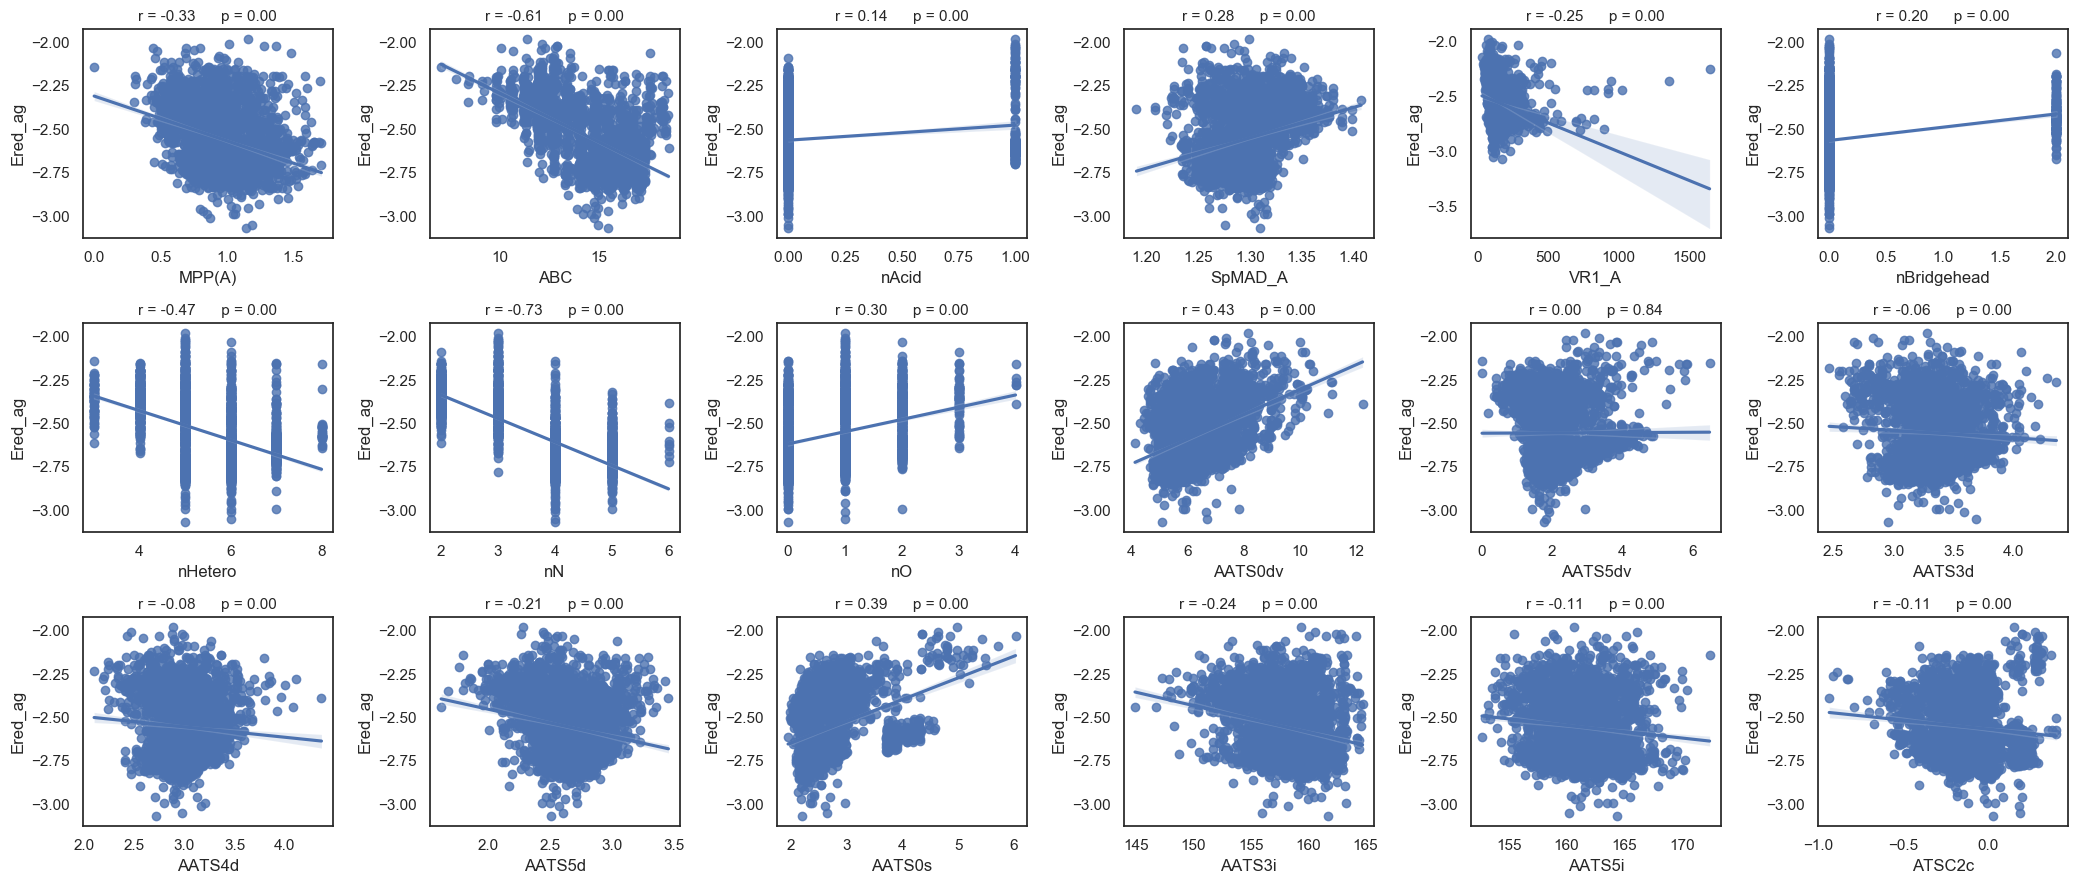

In [245]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_1to18_pearsons.png",dpi=300)
plt.show()  

# 19-36 out of the 63 features

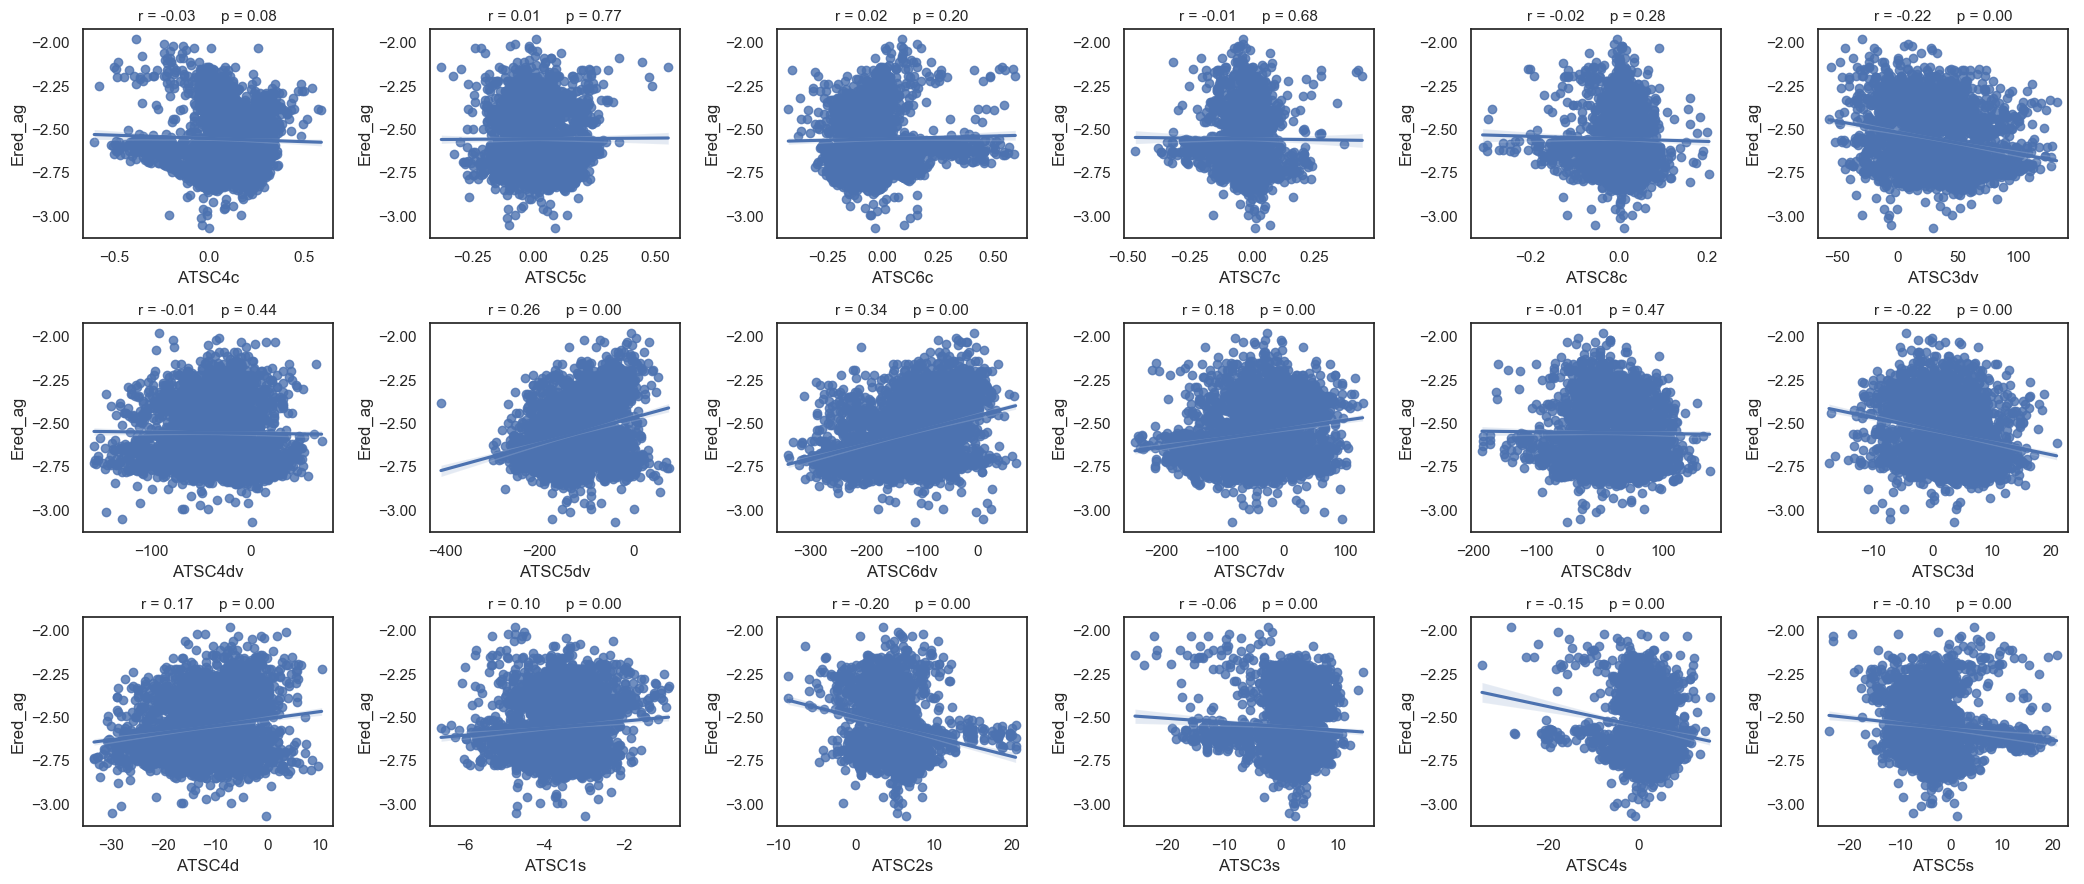

In [246]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_19to36_pearsons.png",dpi=300)
plt.show()  

# 37 to 54 out of the 63 features

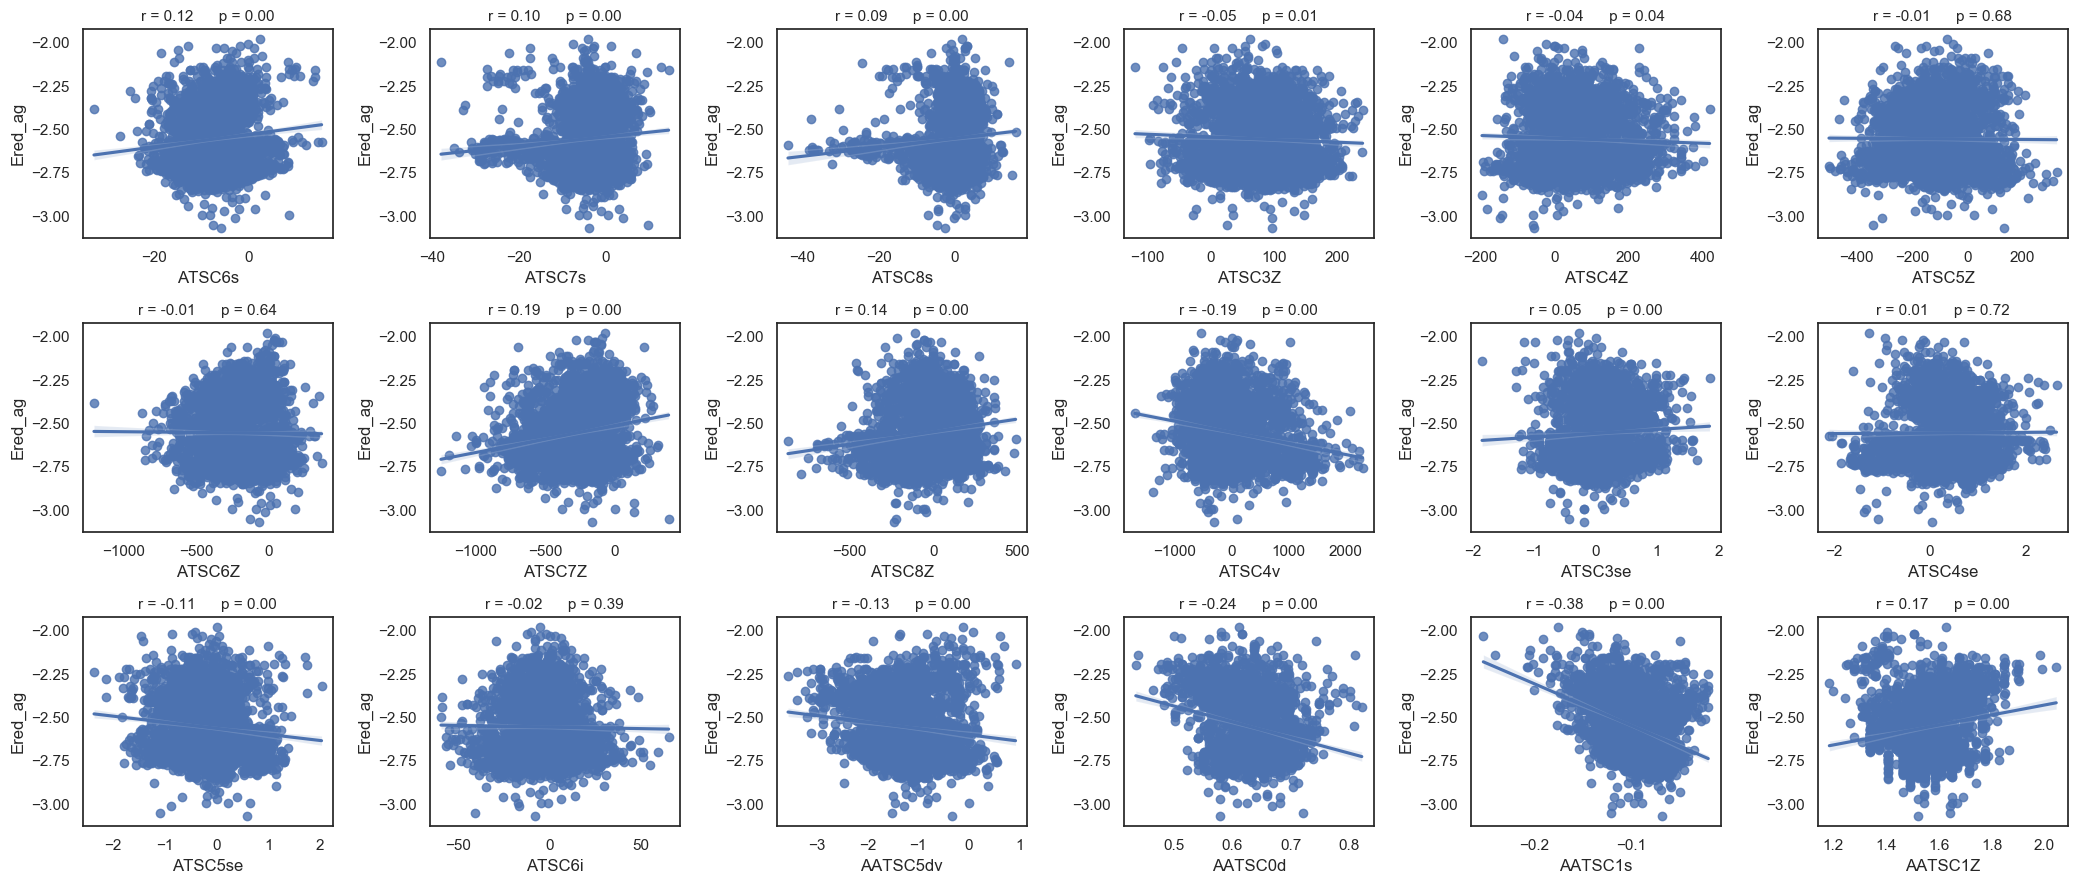

In [247]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_37to54_pearsons.png",dpi=300)
plt.show()  

# 55 to 63 out of the 63 features

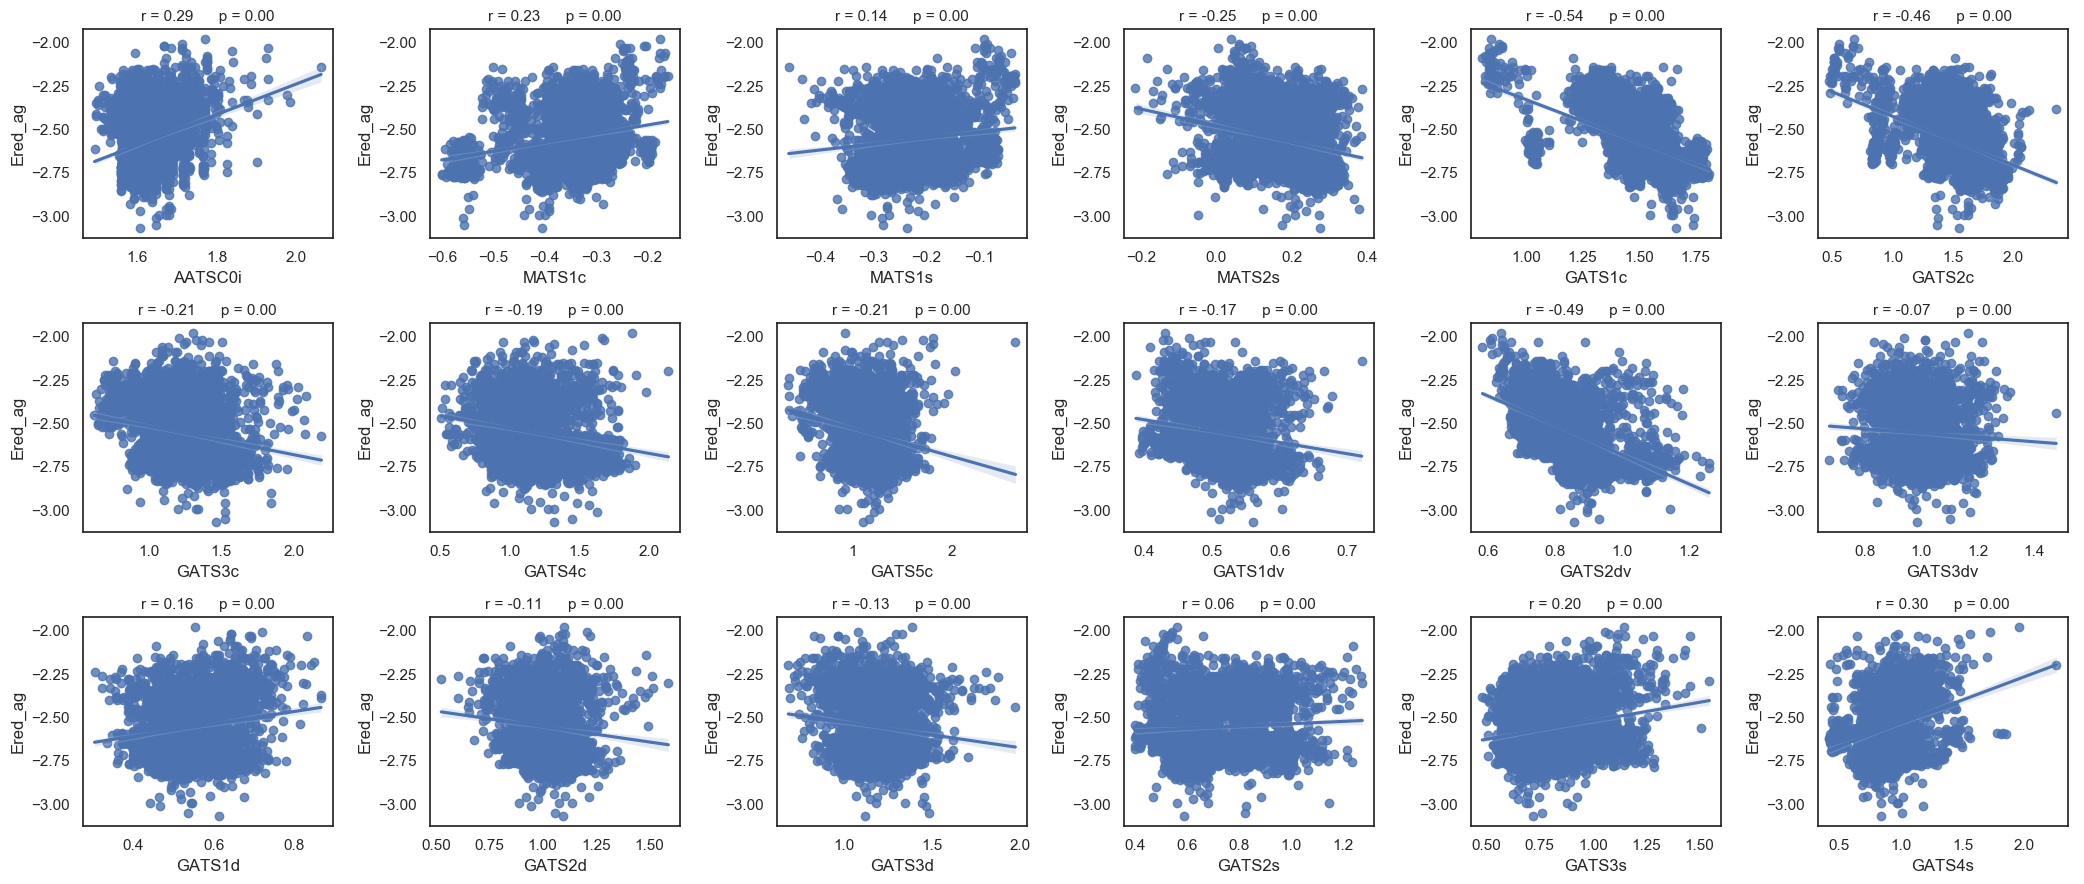

In [248]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_55to72_pearsons.png",dpi=300)
plt.show()  

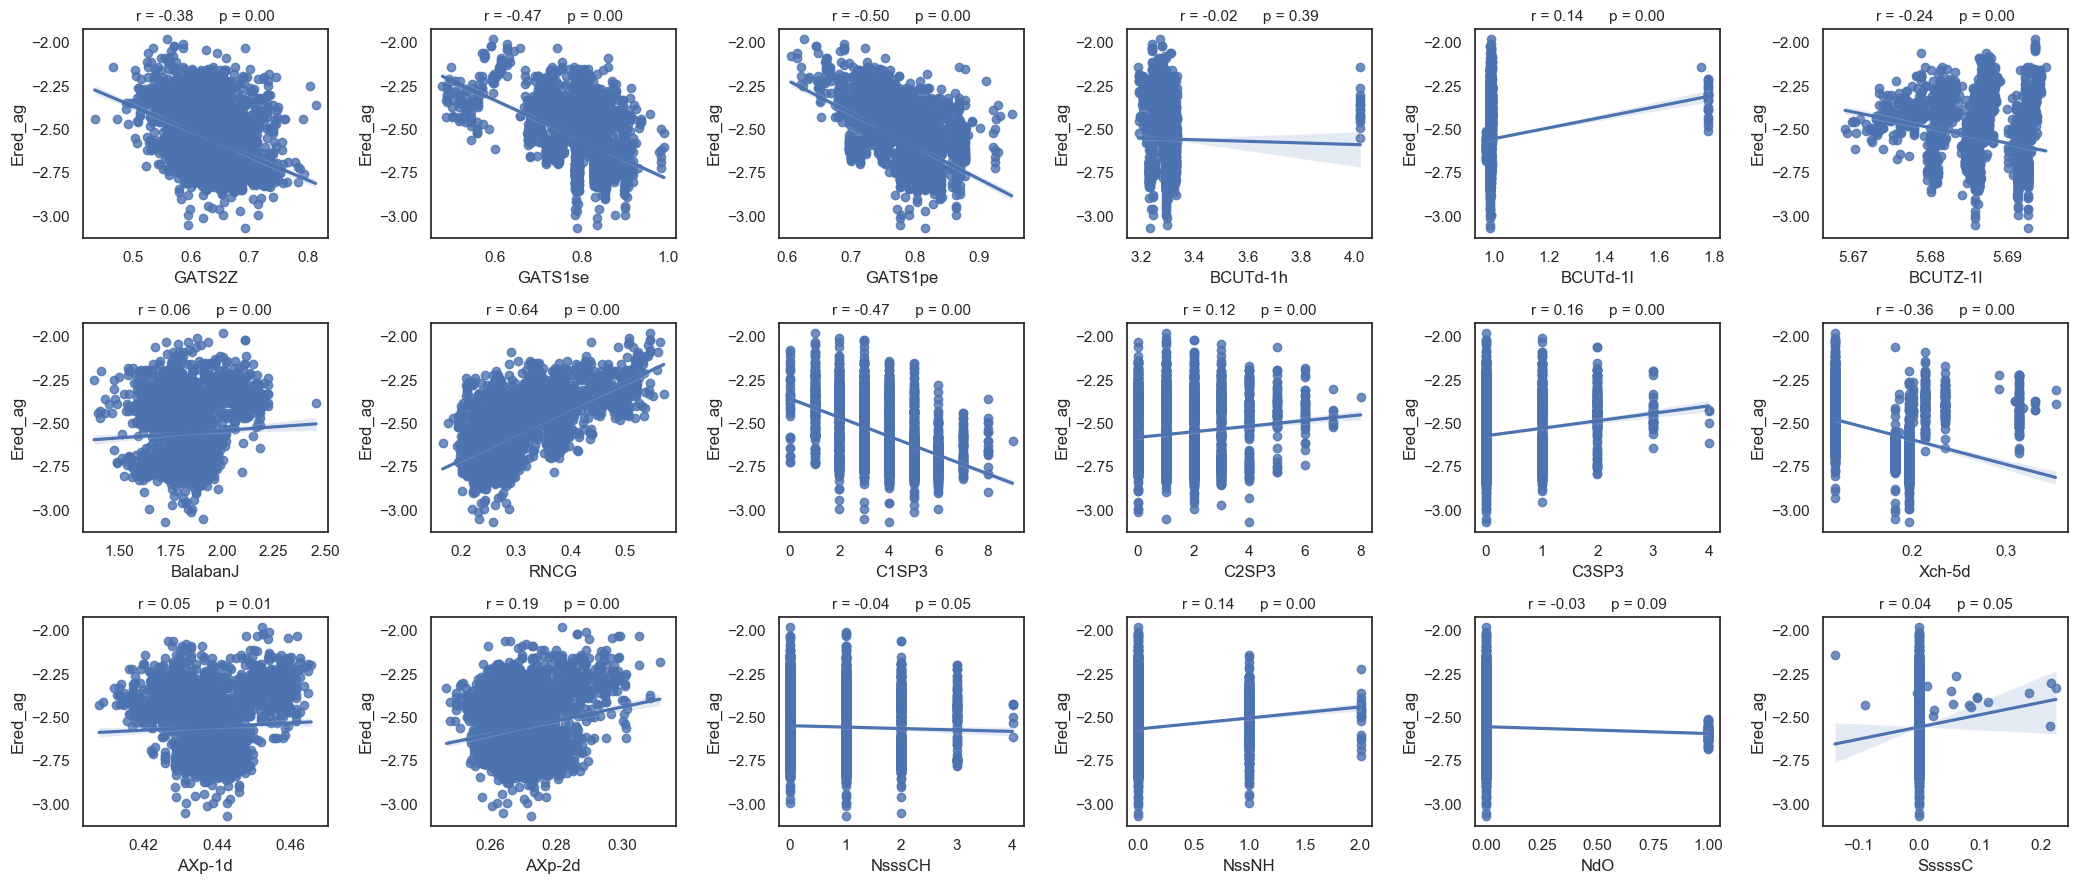

In [249]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_73to90_pearsons.png",dpi=300)
plt.show()  

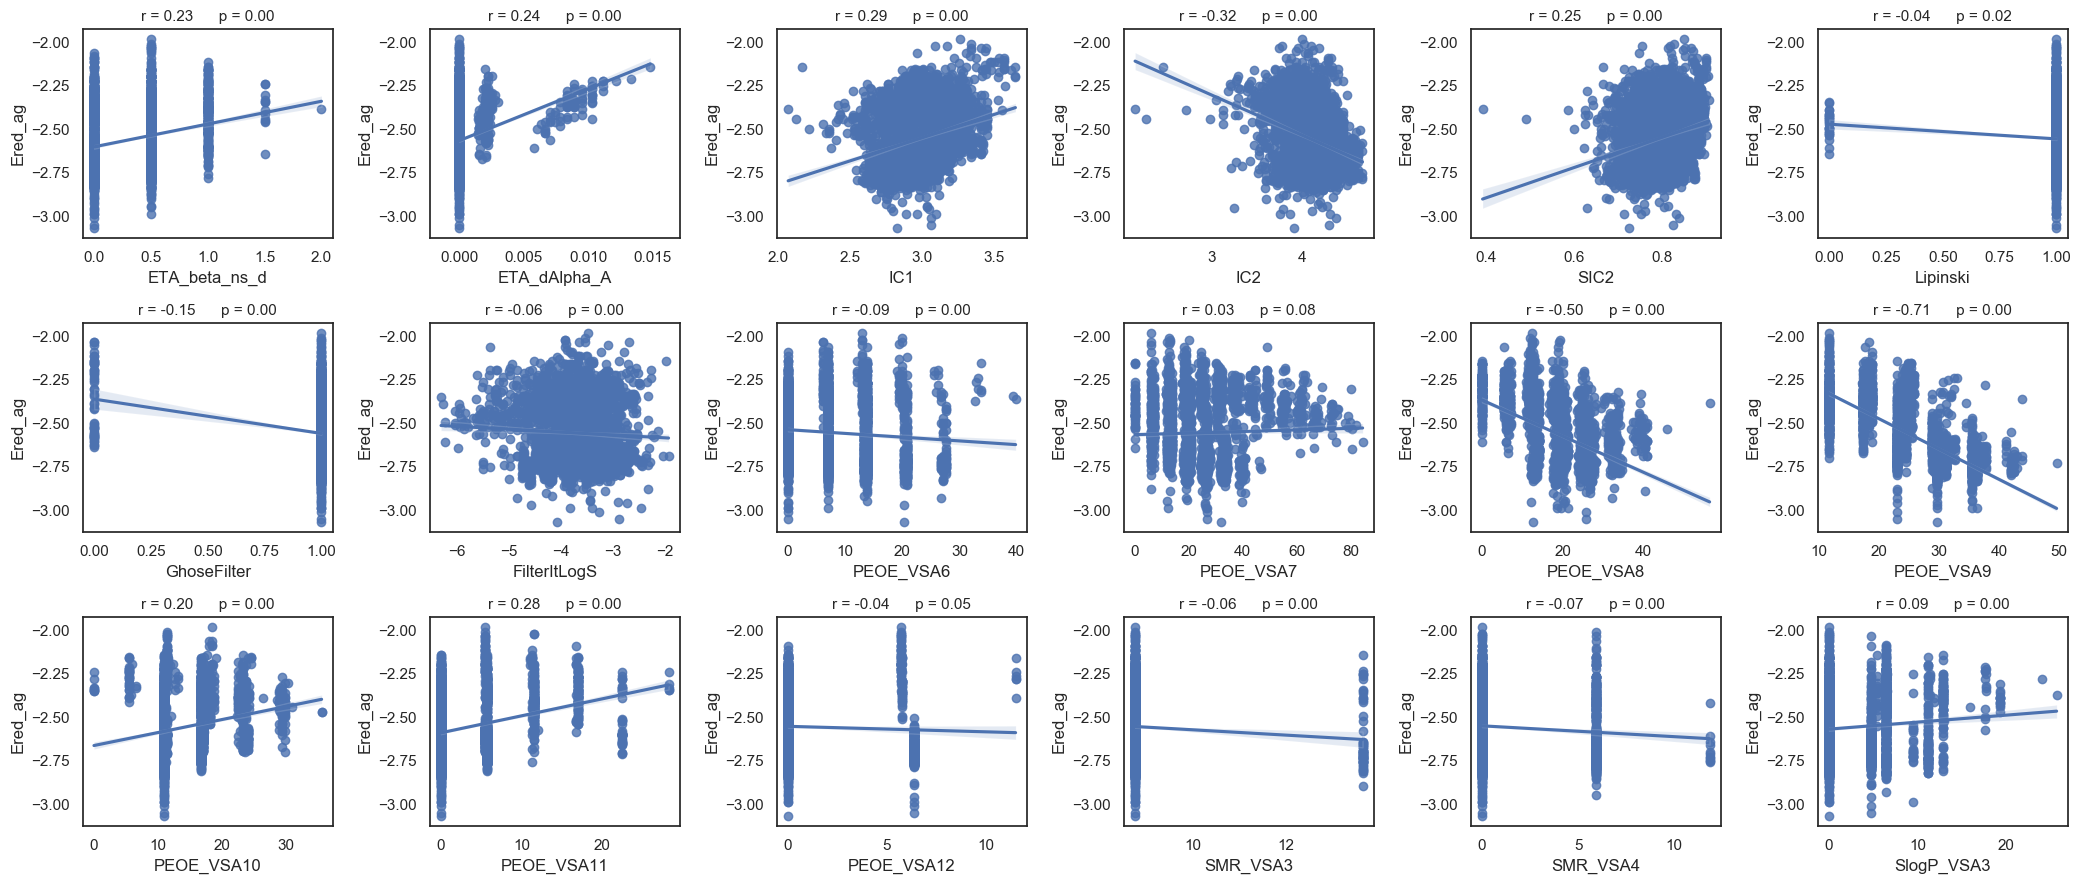

In [250]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_91to108_pearsons.png",dpi=300)
plt.show()  

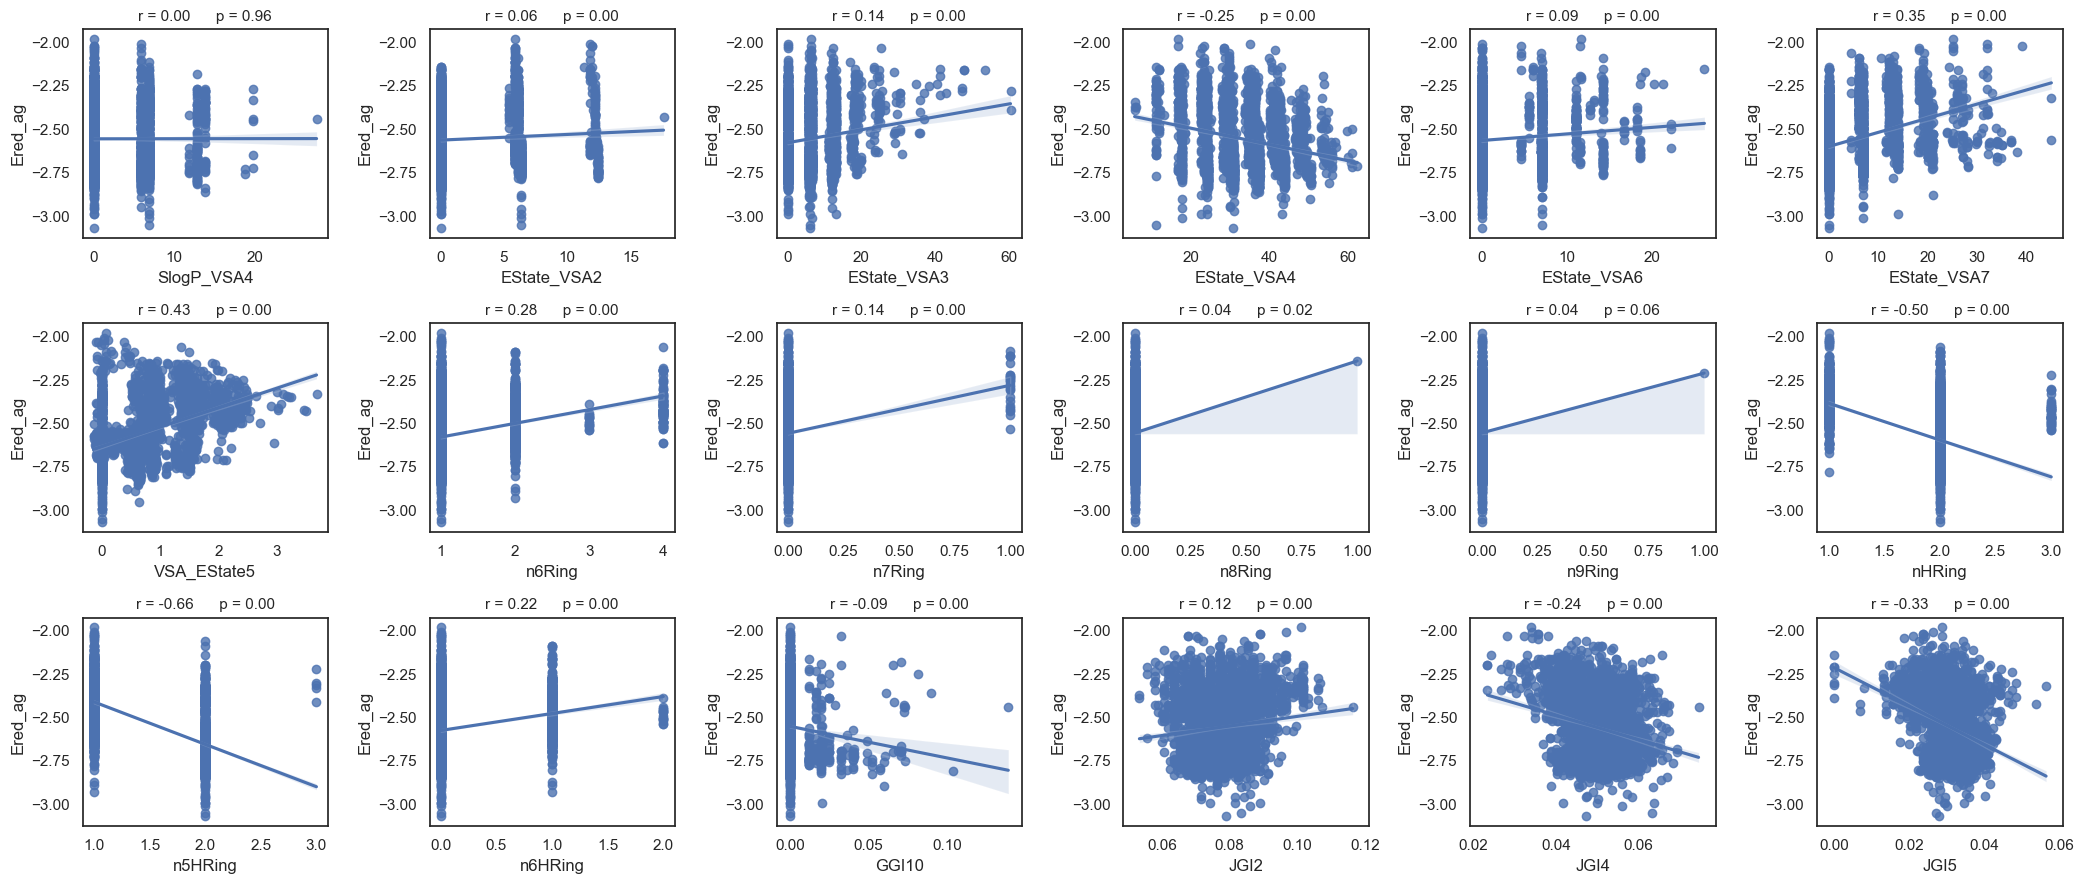

In [251]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_109to126_pearsons.png",dpi=300)
plt.show()  

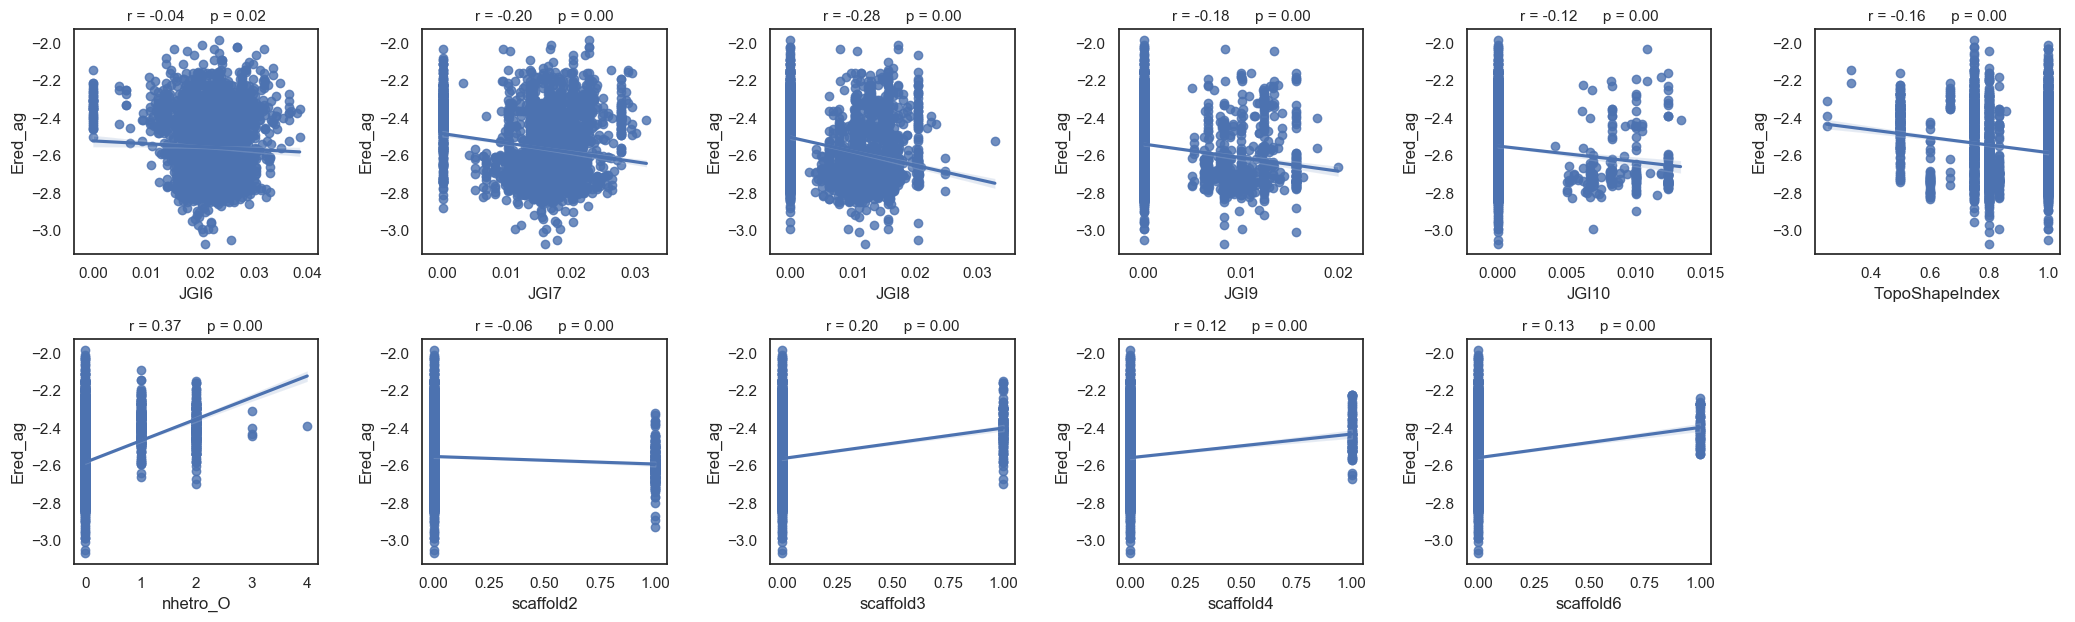

In [252]:
target = 'Ered_ag'
descriptors=df_rdkit_uncorr.columns
# corr_ered_feat=[]
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18+18+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
plt.savefig(folder_path+"Ered_features_127to144_pearsons.png",dpi=300)
plt.show()  

# 35 (20+15) Descriptors with a high positive and negative pearson's corre. coeff.

In [253]:
corr_ered_feat=pd.DataFrame(corr_ered_feat,columns=["Descriptors","Pearsons"])

remove_desc2=[i for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]
corr_ered_feat=corr_ered_feat.drop(remove_desc2)
corr_ered_feat_sorted=corr_ered_feat.dropna(axis=0).sort_values("Pearsons")

# Select most dominant features

In [254]:
df_reducedDescp=pd.concat([corr_ered_feat_sorted[:20],corr_ered_feat_sorted[-15:]])

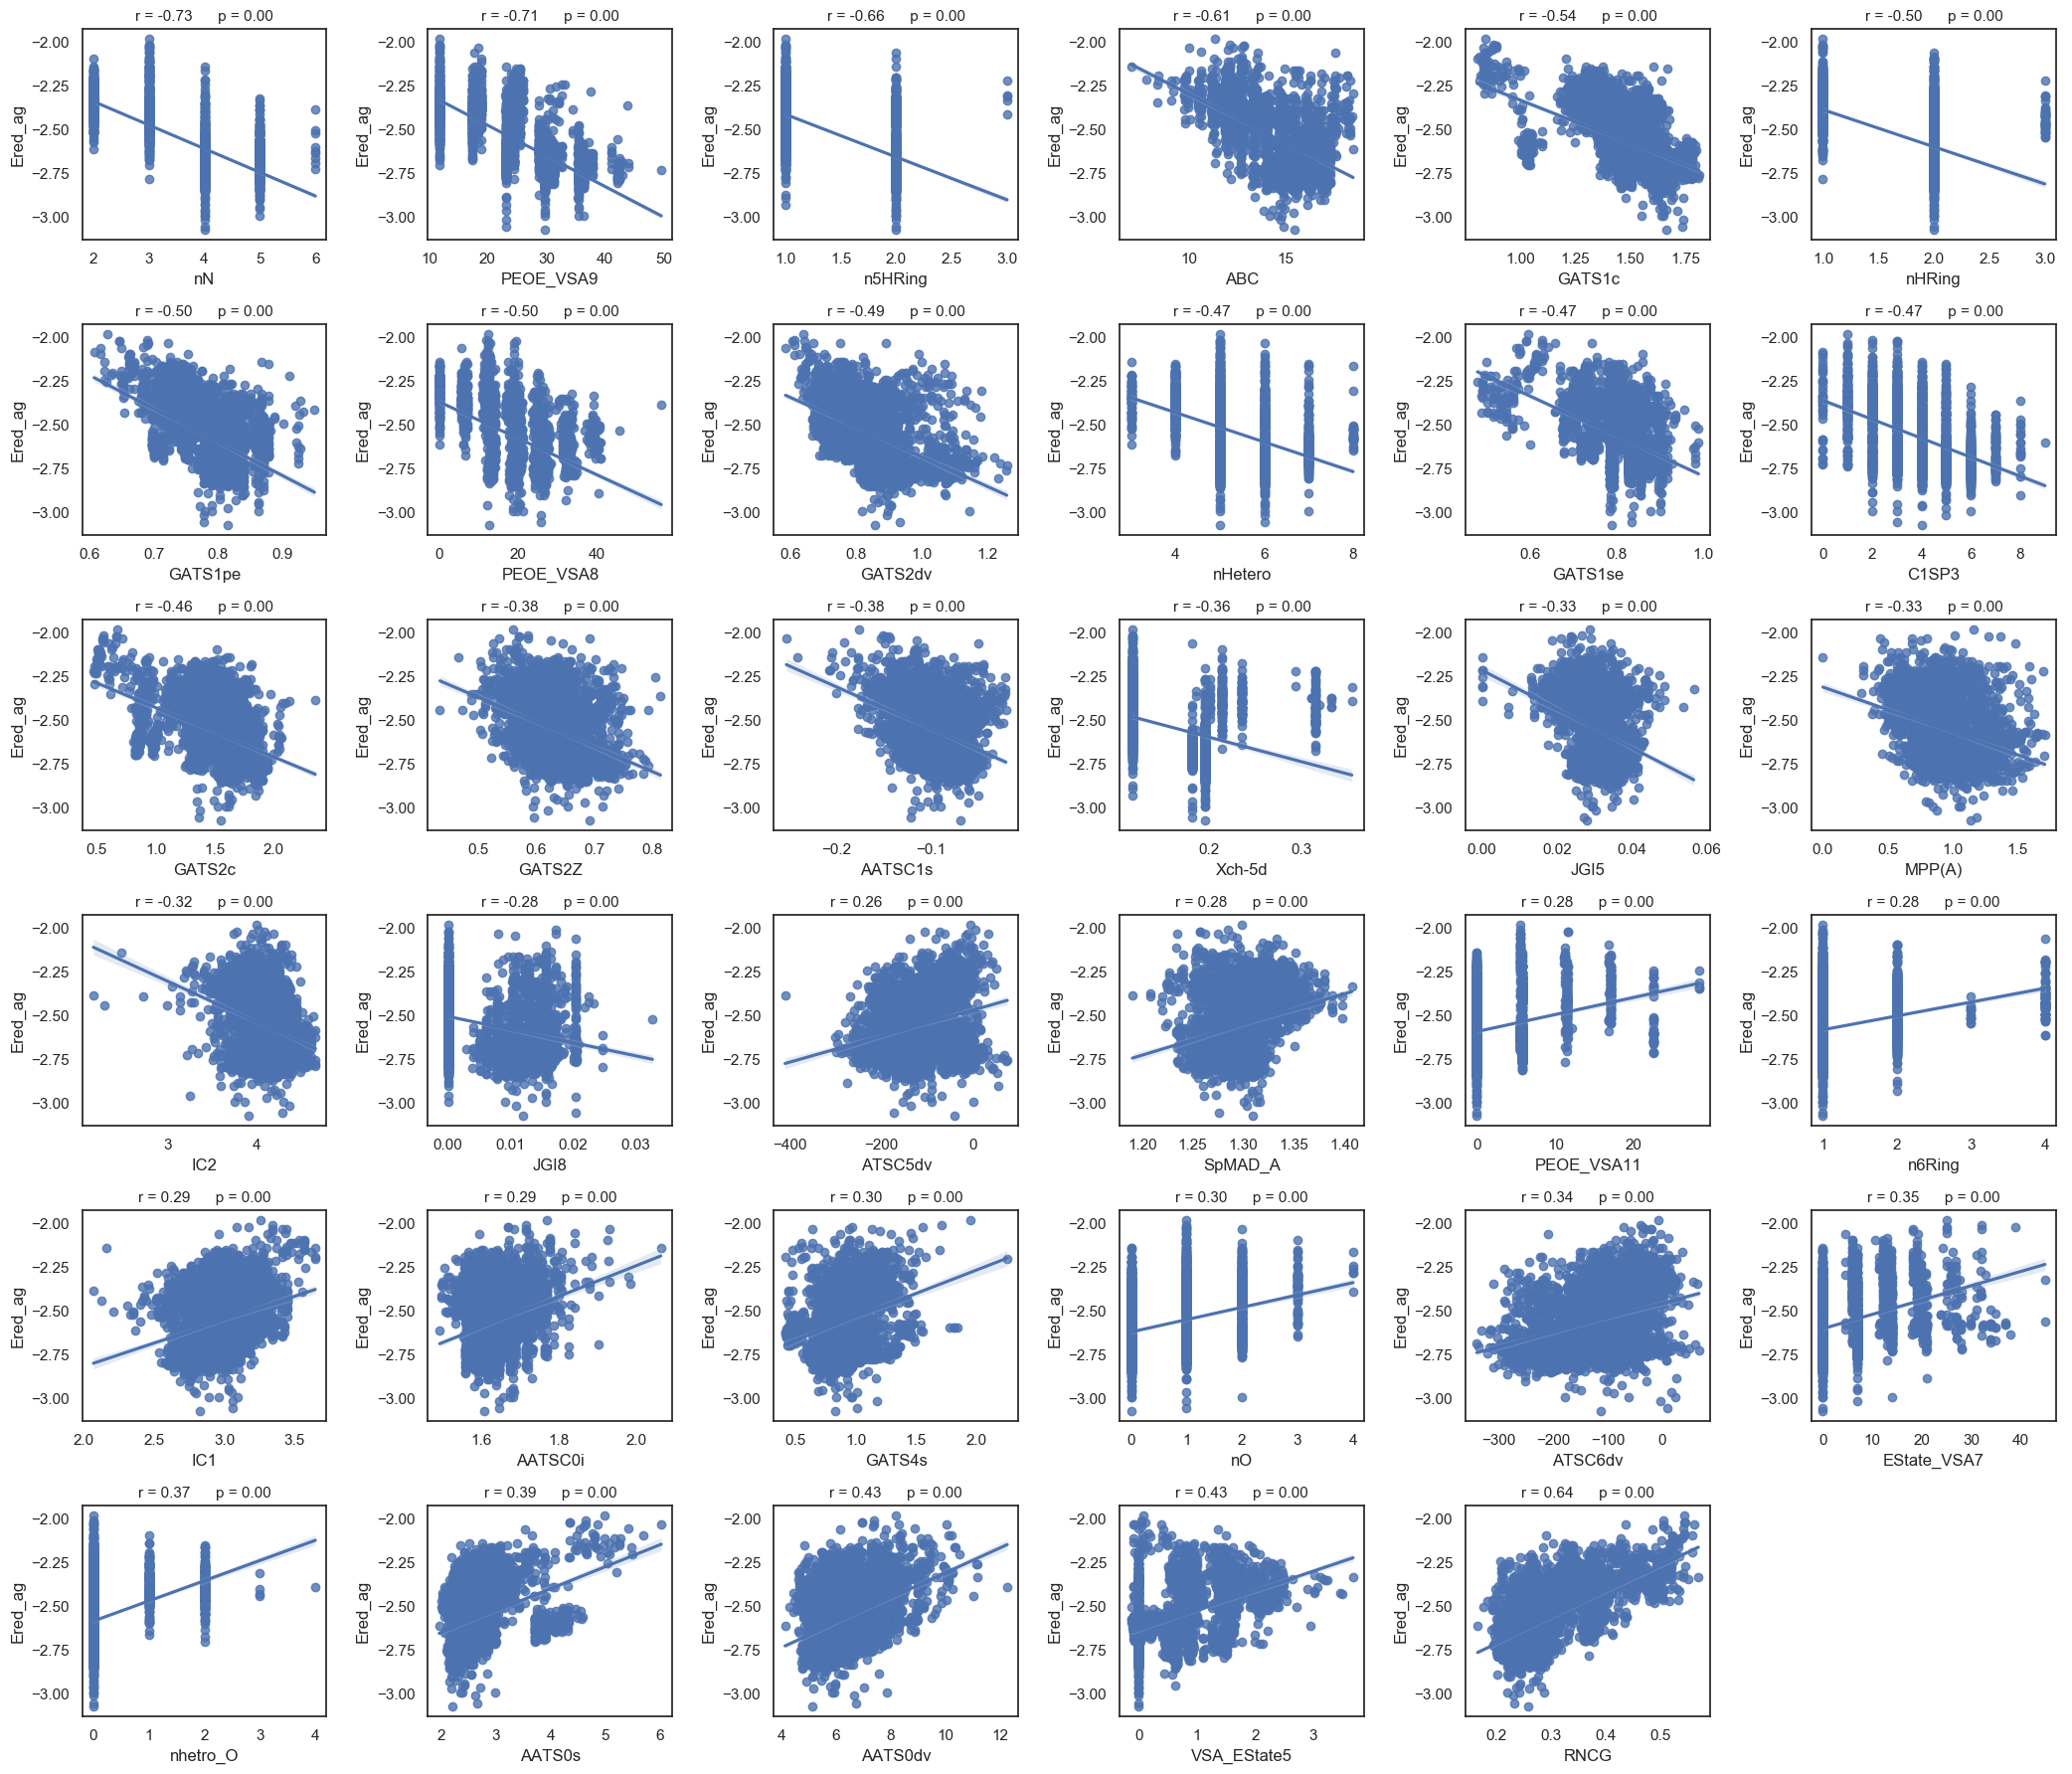

In [255]:
target = 'Ered_ag'
descriptors=df_reducedDescp.Descriptors.to_list()

nr_rows = 6
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=df_rdkit_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(df_rdkit_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
plt.savefig(folder_path+"Ered_and_30dominat_features.png",dpi=300)
plt.show()  

# Got same features as simple mordred

# Make two feature sets, (1) only 30 dominant features and (2) all 63 features

In [256]:
df_rdkit_uncorr_30=df_rdkit_uncorr.loc[:,df_reducedDescp["Descriptors"].to_list()]

# Check GPR model (GPytorch implementation) performance

In [257]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


import torch, gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

# Machine learning-realated functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For normalizing inputs
from sklearn.decomposition import PCA # Principle component analysis

In [258]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [259]:
def do_pca(xtrain=None, xtest=None, rvar=None, npc=None):
    """
    Usage: do_pca(xtrain=xtrain, xtest=test) 
    Caution: Do test_train_split and scaling before pca
    Return: Transformed xtrain and xtest if they are not None
    """
    
    if xtrain is not None:
        
        pca = PCA().fit(xtrain)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if rvar is not None and npc is None:
            n_comp = 1+np.nonzero(evr > rvar)[0][0]
            print(str(n_comp)+" principal components can describe > "+ str(rvar*100)+ "% of variance in the data")
        elif rvar is None and npc is not None:
            n_comp = npc

        
        print("Selected "+str(n_comp)+" components for PCA")
        
        # col=[]
        # for i in range(1,1+n_comp,1):
        #     col.append("PC"+str(i))

        pca = PCA(n_components=n_comp)
        xtrain = pca.fit_transform(xtrain) 
        # xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=pca.transform(xtest)
            # xtest=pd.DataFrame(xtest,columns=col)
            print("returning pca transformed train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only transformed train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [260]:
from sklearn.preprocessing import StandardScaler, RobustScaler
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [261]:
def gpr_one_pytorch(X,y,train_pc=0.8):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)

    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [262]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)
     
    if showfig:
        plt.figure(figsize=(6, 6)) 
        plt.tick_params(reset=True)

        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.2,y_true_train.max()+0.2],[y_true_train.min()-0.2,y_true_train.max()+0.2],color='black')
        
        string=f"$R^2$={r2_train:0.2f}, RMSE = {rmse_train:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.03,string,color='red')
        

        string=f"$R^2$={r2_test:0.2f}, RMSE = {rmse_test:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.15,string,color="blue")

        plt.rc('font', size=20)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        plt.xlim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.ylim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.xticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))        
        plt.yticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))
        
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

# with all 63 features (no PCA for now)
## 80% train and 20% test data

In [263]:
X=df_rdkit_uncorr
y=ERed_data["Ered_ag"]
# 
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)


returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


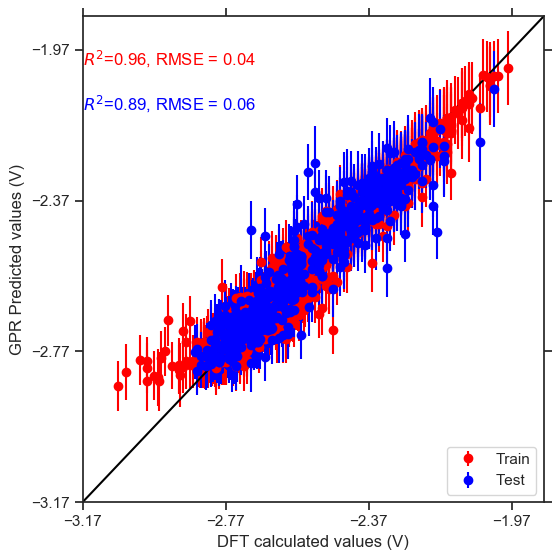

In [264]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,filename=folder_path+"GPR_noPCA_63feat.png",data=False)

# With only 30 dominant features (no PCA)
# 80%-20% train-test split

In [265]:
X=df_rdkit_uncorr_30
y=ERed_data["Ered_ag"]
# 
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)


returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


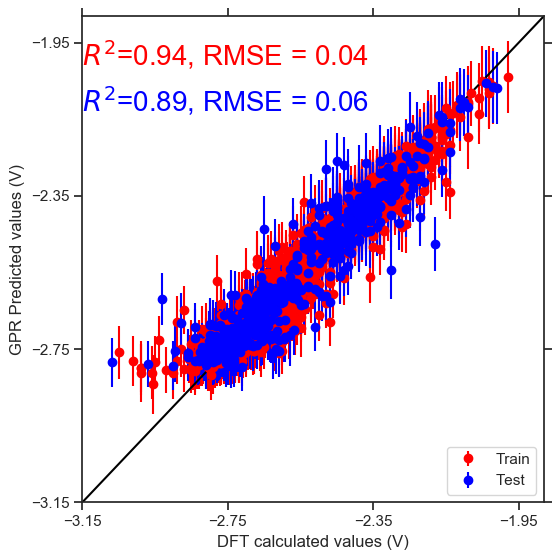

In [266]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,filename=folder_path+"GPR_noPCA_30feat.png",data=False)

# PCA with all 63 features  

In [267]:
del X, X_st, pca

test data is not provided, returning only scaled train data


C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.994972                                                                        
2                   0.995623                                                                        
3                   0.996167                                                                        
4                   0.996619                                                                        
5                   0.997015                                                                        
6                   0.997387                                                                        
7                   0.997732                                                                        
8                   0.998051                                                                        
9                   0.998279            

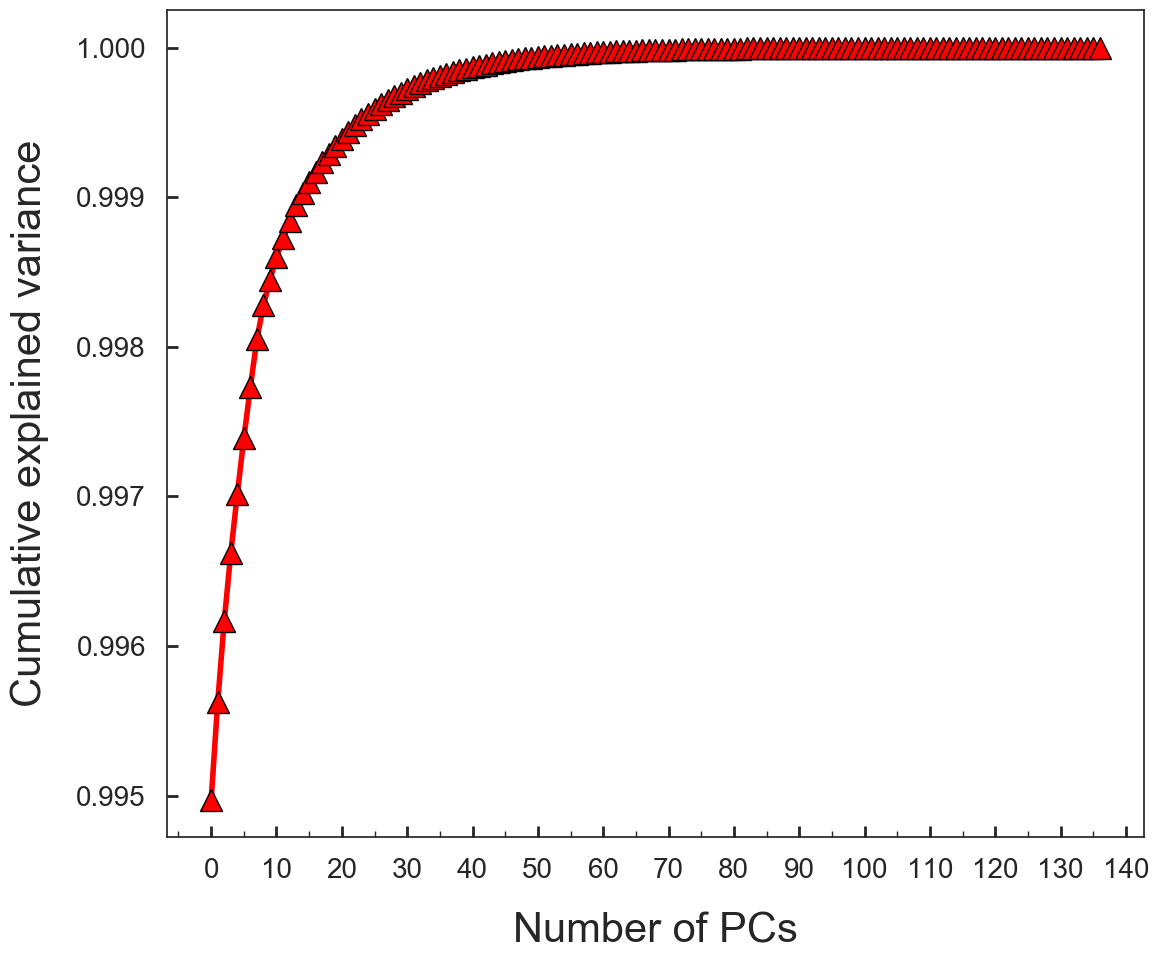

In [268]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)


X=df_rdkit_uncorr

X_st= do_scaling(scaler=RobustScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
plt.savefig(folder_path+"pca_63features.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# PCA with 30 features 

In [269]:
del X, X_st, pca

test data is not provided, returning only scaled train data


C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.283220                                                                        
2                   0.452272                                                                        
3                   0.548191                                                                        
4                   0.622876                                                                        
5                   0.695536                                                                        
6                   0.741957                                                                        
7                   0.781103                                                                        
8                   0.816872                                                                        
9                   0.841702            

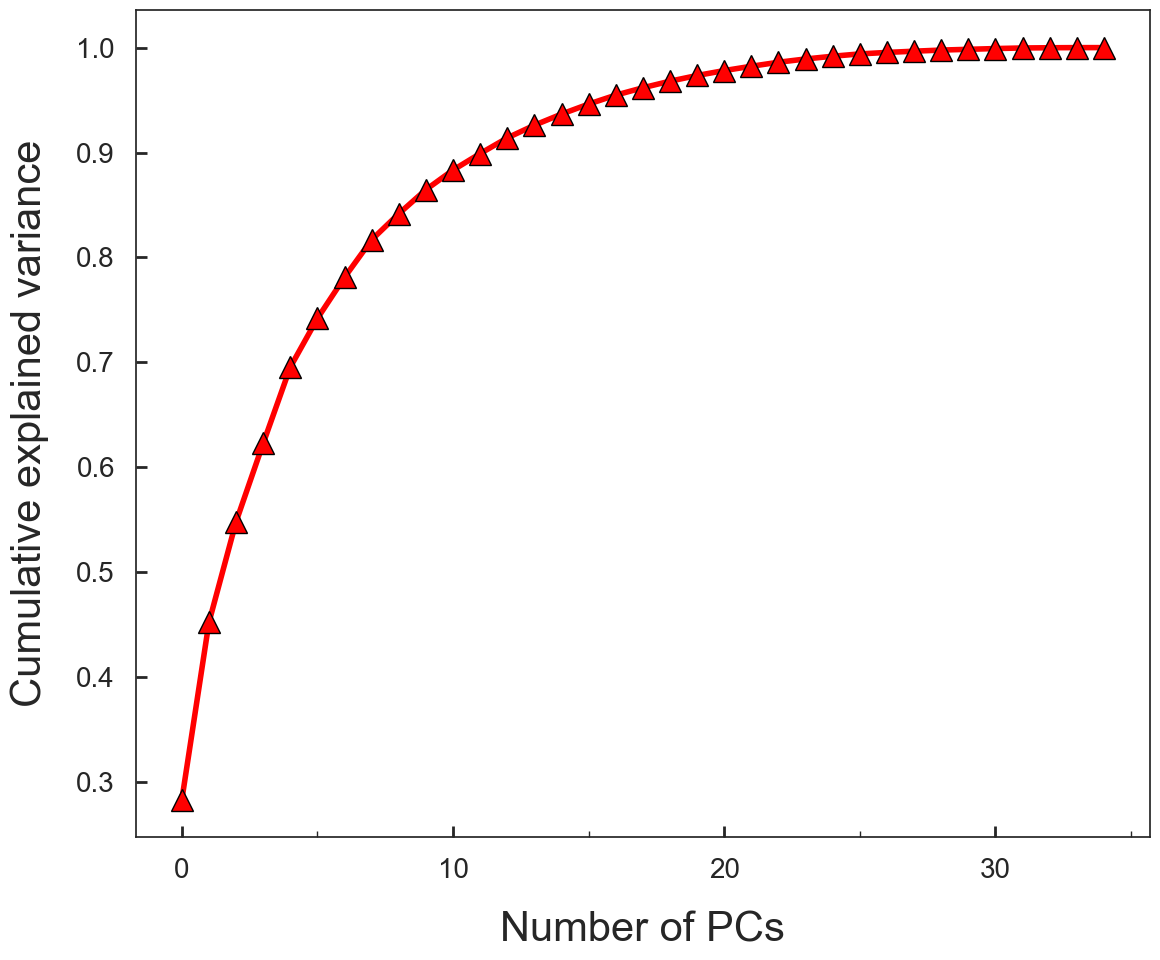

In [270]:
X=df_rdkit_uncorr_30

X_st= do_scaling(scaler=RobustScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
plt.savefig(folder_path+"pca_30features.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Distribution of Ered as a function of the 1st and 2nd PCs that describe most cumulative variance

## PCA with all 63 features

In [271]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
del X
X=df_rdkit_uncorr.copy()
X=do_scaling(xtrain=X)
Xdata = pca.fit_transform(X)  # Transform feature vectors to PCs

test data is not provided, returning only scaled train data


In [272]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata=pd.DataFrame(Xdata,columns=col_txt)
df_xdata.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.348144  0.346672 -4.499395 -3.963522  4.086401  1.856186 -2.486561   
1  0.002196  1.449490 -1.659037 -3.906350  4.469927 -2.112221 -2.370428   
2 -2.772210 -1.170920 -1.254619 -3.984512  0.203257  3.799725 -1.608137   
3 -4.389217 -2.873319 -1.154110 -3.399325  2.351100  1.230236 -0.840808   
4 -2.994935 -2.711352 -2.038708 -3.840356  0.532957  3.214631 -0.935464   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -3.008277  1.492297  0.395440  5.092608  1.943019 -1.998800  1.746840   
1  0.040809  2.409296  0.153749  4.114757  0.403784  1.014379  1.832930   
2  0.950861  4.782336  0.473504  1.070539  2.059467  1.622257 -1.026678   
3  4.260778  4.489827 -0.921730  0.963847  1.536020  1.808560 -0.274461   
4  2.440657  5.690248  0.490189  1.298728  1.198281  1.049066 -0.816557   

       PC15      PC16  
0  1.319952  1.076869  
1  2.298987  0.704075  
2  0.053848  0.688863  
3  0.807304  0.915043  
4  0.268122  1.013798

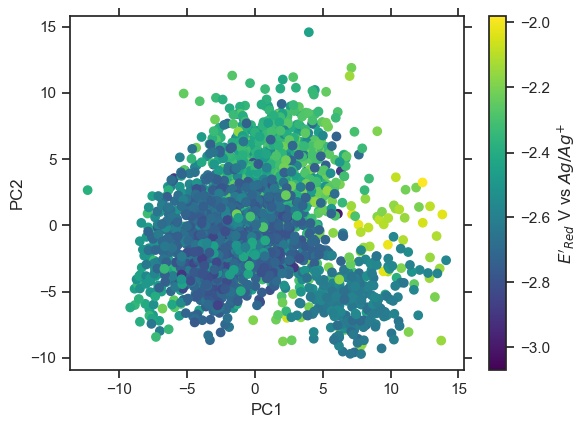

In [273]:
plt.tick_params(reset=True)
plt.scatter(x=df_xdata.PC1,y=df_xdata.PC2,c=ERed_data.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")

plt.tight_layout()
plt.savefig(folder_path+"PC1_PC2_ERed_Ag_with63feat_PCA.png",dpi=300)
plt.show()

# PCA with 30feat

In [274]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
del X
X=df_rdkit_uncorr_30.copy()
X=do_scaling(xtrain=X)
Xdata = pca.fit_transform(X)  # Transform feature vectors to PCs

test data is not provided, returning only scaled train data


In [275]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata_30=pd.DataFrame(Xdata,columns=col_txt)
df_xdata_30.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.473448  1.017340 -0.703205 -2.822622 -1.161308 -2.337583  1.053096   
1 -2.908403  0.091812  0.348734 -2.530688 -2.306312 -2.064410  0.662887   
2 -3.808353  0.560605 -0.295787 -1.154194  1.159295 -1.913207  2.429540   
3 -4.357098  1.497168  0.748952 -1.566992  0.027565 -1.808171  1.871465   
4 -4.375171  1.287165  0.264253 -0.906604  1.270345 -2.085193  2.300080   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.260109  2.046260  1.097765  0.564041 -0.523680  1.035149 -0.996323   
1  0.328119  1.831250 -0.221202  0.087176 -1.164825 -0.312652 -0.384660   
2 -1.093528 -0.113574  0.112209 -0.949850  0.017386 -0.232319  0.392613   
3 -1.241963  0.397334  0.525112 -1.821153  0.682610 -0.135051 -0.594311   
4 -1.372054  0.738995  0.601520 -1.700401  0.452644 -0.239915  0.232931   

       PC15      PC16  
0  0.780998  0.524406  
1  1.515066  0.079537  
2 -0.306803  0.491612  
3  0.755582  0.369290  
4 -0.116092  0.490737

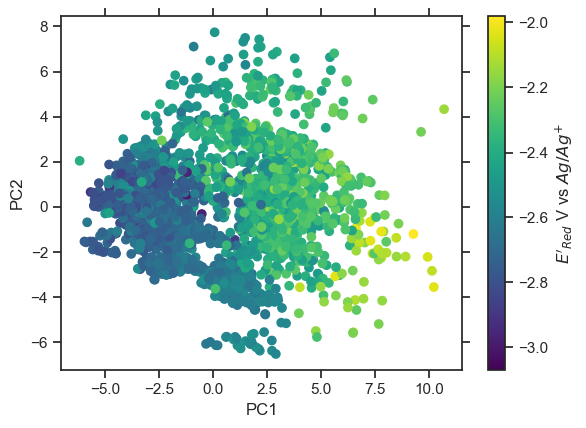

In [276]:
plt.tick_params(reset=True)
plt.scatter(x=df_xdata_30.PC1,y=df_xdata_30.PC2,c=ERed_data.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")

plt.tight_layout()
plt.savefig(folder_path+"PC1_PC2_ERed_Ag_with30feat_PCA.png",dpi=300)
plt.show()

Similar distribution of Ered with the PCs of both 30 and 63 features

# Learning curves for num_PCs and train-test split%
## 17 or more PCs made with 30 dominant features can describe at least 99% cumulative variance in data
## 29 or more PC made with 63 features can describe at least 99% cumulative variance in data
## Hence, using only 30 dominant features to obtain learning curves


In [277]:
def gpr_one_pca_pytorch(X,y,train_pc=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    # print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [278]:
def helper(X,y,nPC=5,train_pc=0.8,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=train_pc,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [279]:
train_pcs = [0.2, 0.4, 0.6, 0.8 , 0.9]
num_PCs = [5, 10, 17, 25, df_rdkit_uncorr_30.shape[1]]

In [280]:
train_pcs_avg_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_avg_test_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_test_score=np.zeros([len(train_pcs),len(num_PCs),3])

# Be patient next block of code will take time to complete
## will repeat experiments 10 times to get statistics

In [281]:
from tqdm import tqdm
import time

In [282]:
%%capture
repeats=10
for jdx,tr_pc in enumerate(tqdm(train_pcs,position=0, desc="train_pcs", leave=False, colour='green', ncols=80)):

    avg_train_score = np.zeros([len(num_PCs),3])
    avg_test_score = np.zeros([len(num_PCs),3])

    std_train_score = np.zeros([len(num_PCs),3])
    std_test_score = np.zeros([len(num_PCs),3])

    for idx,PCs in enumerate(tqdm(num_PCs,position=1,desc="num_PCs", leave=False, colour='blue', ncols=80)):

        X=df_rdkit_uncorr_30
        y=ERed_data.Ered_ag.to_list()
        
        
        r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
        r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

        for j in tqdm(np.arange(repeats),position=2,desc="repeats",leave=False,colour="red",ncols=80):
            # print(f" ---> %repeat <-- ={100*j/repeats}")
            r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs,train_pc=tr_pc)

        avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
        avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
        std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
        std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()

    # store scores for each tr_pc
    train_pcs_avg_train_score[jdx] = avg_train_score
    train_pcs_avg_test_score[jdx] = avg_test_score
    train_pcs_std_train_score[jdx] = std_train_score
    train_pcs_std_test_score[jdx] = std_test_score

# Plot curves

In [283]:
y_r2_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_4pc=[train_pcs_std_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_4pc=[train_pcs_std_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_4pc=[train_pcs_std_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_8pc=[train_pcs_std_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_8pc=[train_pcs_std_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_8pc=[train_pcs_std_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_16pc=[train_pcs_std_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_16pc=[train_pcs_std_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_16pc=[train_pcs_std_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_32pc=[train_pcs_std_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_32pc=[train_pcs_std_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_32pc=[train_pcs_std_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_46pc=[train_pcs_std_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_46pc=[train_pcs_std_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_46pc=[train_pcs_std_train_score[x][4][2] for x in np.arange(len(train_pcs))]

In [284]:
len(y_r2_avg_tr_10_16pc),len(train_pcs),len(y_r2_std_tr_10_16pc)

(5, 5, 5)

In [285]:
train_pcs=np.array(train_pcs)

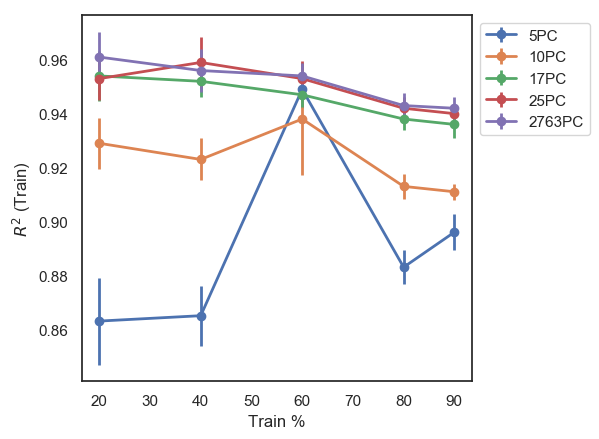

<Figure size 640x480 with 0 Axes>

In [286]:
# plt.tick_params(reset=True)
# plt.rcParams['ytick.labelsize'] = 25
# plt.rc('font', size=20) 
# plt.figure(figsize=(4,6))

plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_4pc,yerr=y_r2_std_tr_10_4pc,fmt='-o',label="5PC",linewidth=2)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_8pc,yerr=y_r2_std_tr_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_16pc,yerr=y_r2_std_tr_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_32pc,yerr=y_r2_std_tr_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_46pc,yerr=y_r2_std_tr_10_46pc,fmt='-o',label=f"{df_rdkit_uncorr_30.shape[0]}PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Train)")
# plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()
plt.savefig(folder_path+"r2_train_learning_curve_train_test_30feat_PCA.png",dpi=300)

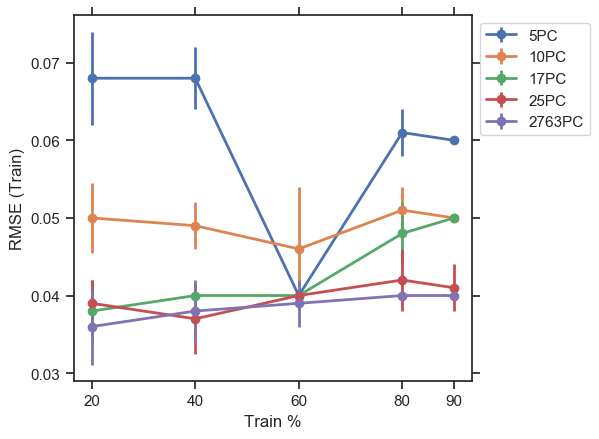

In [287]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_tr_10_4pc,yerr=y_rmse_std_tr_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_8pc,yerr=y_rmse_std_tr_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_16pc,yerr=y_rmse_std_tr_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_32pc,yerr=y_rmse_std_tr_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_46pc,yerr=y_rmse_std_tr_10_46pc,fmt='-o',label=f"{df_rdkit_uncorr_30.shape[0]}PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Train)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_train_learning_curve_train_test_30feat_PCA.png",dpi=300)

In [288]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

# save to npy file
save(folder_path+'train_pcs_avg_test_score.npy', train_pcs_avg_test_score)
save(folder_path+'train_pcs_avg_train_score.npy', train_pcs_avg_train_score)
save(folder_path+'train_pcs_std_test_score.npy', train_pcs_std_test_score)
save(folder_path+'train_pcs_std_train_score.npy', train_pcs_std_train_score)

In [289]:
# # load numpy array from npy file
# from numpy import load
# # load array
# data = load(folder_path+'train_pcs_avg_test_score.npy')
# # print the array
# print(data)

In [290]:
y_r2_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_4pc=[train_pcs_std_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_4pc=[train_pcs_std_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_4pc=[train_pcs_std_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_8pc=[train_pcs_std_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_8pc=[train_pcs_std_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_8pc=[train_pcs_std_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_16pc=[train_pcs_std_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_16pc=[train_pcs_std_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_16pc=[train_pcs_std_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_32pc=[train_pcs_std_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_32pc=[train_pcs_std_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_32pc=[train_pcs_std_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_46pc=[train_pcs_std_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_46pc=[train_pcs_std_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_46pc=[train_pcs_std_test_score[x][4][2] for x in np.arange(len(train_pcs))]


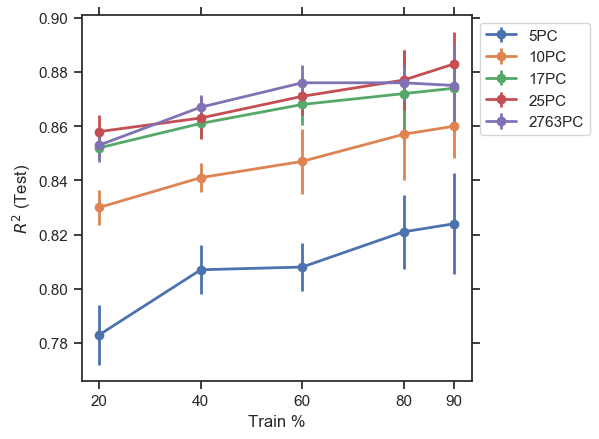

In [291]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_ts_10_4pc,yerr=y_r2_std_ts_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_8pc,yerr=y_r2_std_ts_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_16pc,yerr=y_r2_std_ts_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_32pc,yerr=y_r2_std_ts_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_46pc,yerr=y_r2_std_ts_10_46pc,fmt='-o',label=f"{df_rdkit_uncorr_30.shape[0]}PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Test)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"r2_test_learning_curve_train_test_30feat_PCA.png",dpi=300)

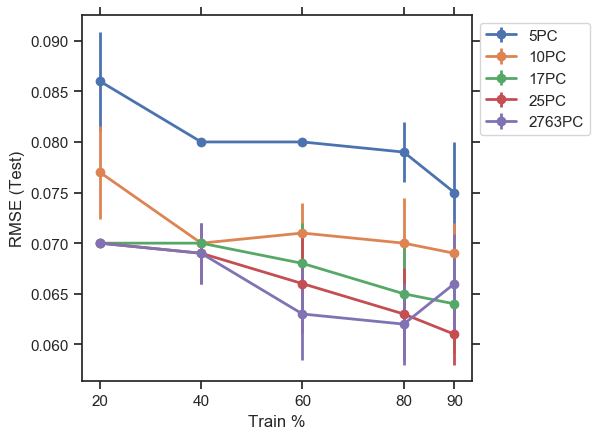

In [292]:
plt.tick_params(reset=True)
# plt.tick_params(axis='both',which='minor')
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_ts_10_4pc,yerr=y_rmse_std_ts_10_4pc,label="5PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_8pc,yerr=y_rmse_std_ts_10_8pc,fmt='-o',label="10PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_16pc,yerr=y_rmse_std_ts_10_16pc,fmt='-o',label="17PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_32pc,yerr=y_rmse_std_ts_10_32pc,fmt='-o',label="25PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_46pc,yerr=y_rmse_std_ts_10_46pc,fmt='-o',label=f"{df_rdkit_uncorr_30.shape[0]}PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Test)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(folder_path+"rmse_test_learning_curve_train_test_30feat_PCA.png",dpi=300)

# Learning curve of PCs at a certain train-test% split

In [293]:
def plot_R2_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning_r2.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,0],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("R$^2$")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

train% = 0.80


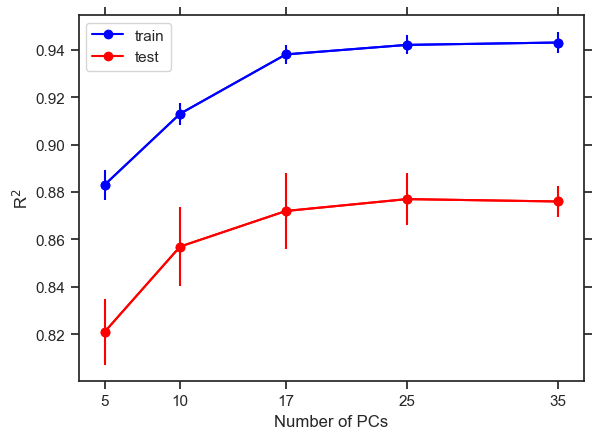

In [294]:
train_pc=-2
print(f"train% = {train_pcs[train_pc]:0.2f}")
plot_R2_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"R2_learning_curve_test_split_80pc_30featPCA_training.png")

In [295]:
def plot_RMSE_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,1],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

train% = 0.80


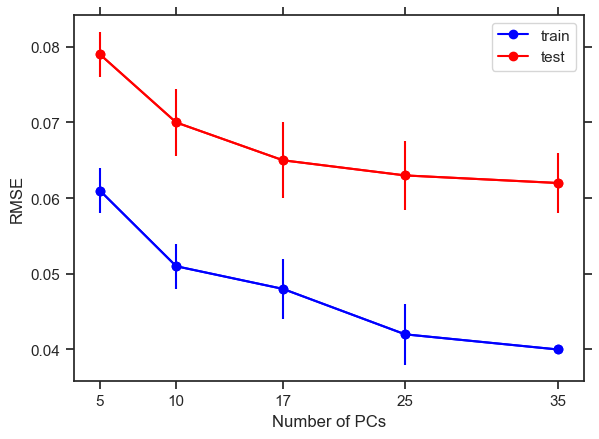

In [296]:
train_pc=-2
print(f"train% = {train_pcs[train_pc]:0.2f}")
plot_RMSE_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=folder_path+"RMSE_learning_curve_test_split_80pc_30featPCA_training.png")

# Final performance

with 17PCs, 80-20% split

In [297]:
# Use 16 PCs and 80-20% train-test split 
X=df_rdkit_uncorr_30  # df_xdata has 16 PCs
y=ERed_data.Ered_ag

y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=17,random_state=1)


returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


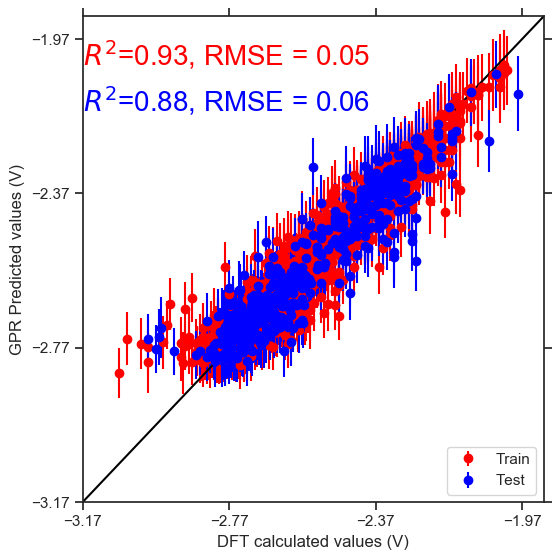

In [298]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_17PCs_8020_2763mols.png")

with 25PCs, 80-20% split, same random state

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


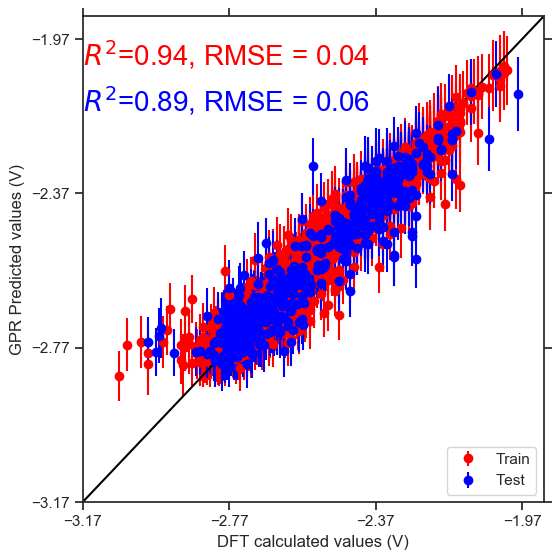

In [299]:
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=25,random_state=1)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_25PCs_8020_2763mols.png")

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


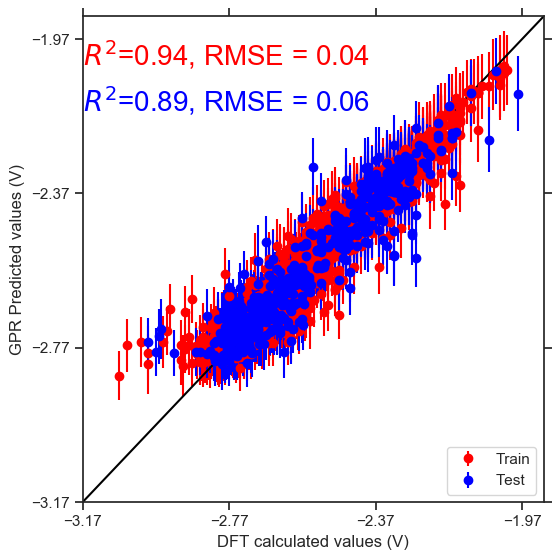

In [300]:
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=0.8,nPC=30,random_state=1)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename=folder_path+"base_model_30PCs_8020_2763mols.png")